# Example: mesh American River Watershed

To replicate this workflow, please make sure the `Watershed-Workflow` version/branch is the same.

```bash
git clone https://github.com/pinshuai/watershed-workflow.git
git switch ARW
```

Note to avoid re-downloading files, make sure to use the data_library located at `~/github/watershed-workflow/data_library`.

```bash
os.environ['WATERSHED_WORKFLOW_DATA_DIR'] = "/Users/shua784/github/watershed-workflow/data_library"
```

In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
%matplotlib inline
# %matplotlib qt

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150

In [13]:
import os,sys
# sys.path.append("./")

# sys.path.append("/Users/shua784/Dropbox/github/seacas/install/lib")

# sys.path.append("/Users/shua784/github")
# sys.path.append("../watershed-workflow")
# sys.path.append("../watershed-workflow/workflow_tpls")
# sys.path.append("../watershed-workflow/workflow")
sys.path.append("/Users/shuai/github/my-workflow")
sys.path.append("/Users/shuai/github/my-workflow/workflow_tpls")
sys.path.append("/Users/shuai/github/my-workflow/workflow")
# sys.path.append("/Users/shua784/github/myfunctions")
# import myfunctions.ATSutils as utils
# import myfunctions.general_plots as gp

In [29]:
# os.environ['WATERSHED_WORKFLOW_DATA_DIR'] = "/Users/shua784/github/watershed-workflow/data_library"

In [15]:
# import os,sys
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import cm as pcm
# from matplotlib_scalebar.scalebar import ScaleBar
import shapely
import logging
import fiona
import rasterio
import pickle
import seaborn as sns
# from sklearn.cluster import KMeans

import workflow
import workflow.source_list
import workflow.ui
import workflow.colors
import workflow.condition
# import workflow.mesh
import workflow.split_hucs

workflow.ui.setup_logging(1,None)
figsize = (6,6)
figsize_3d = (8,6)

In [16]:
import scipy
scipy.__version__

from scipy.ndimage import gaussian_filter

In [17]:
from IPython.display import HTML
from matplotlib import animation

In [18]:
def doArraysIntersect(array1, array2):
    return bool(set(array1) & set(array2))

In [19]:
watershed_name = "American"
meshRes = "250m"

riverbed_tckness = 0.0 #m
# fname_surface_mesh = f"./meshes/{watershed_name}_surface_mesh.vtk"
fname_final_mesh = f"../data/meshes/{watershed_name}_riverbed_res{meshRes}_tck{str(riverbed_tckness)}m.exo"

fig_mesh = f"./figures/{watershed_name}_riverbed_2Dmesh-{meshRes}.png"
fig_mesh3D = "./figures/{}_mesh3D.png".format(watershed_name)
fig_soil_type = "./figures/{}_soil_type.png".format(watershed_name)
fig_geol_map = "./figures/{}_geol_map.png".format(watershed_name)
fig_land_cover = "./figures/{}_land_cover.png".format(watershed_name)
fig_hru = "./figures/{}_HRU.png".format(watershed_name)
fig_DTB = "./figures/{}_DTB.png".format(watershed_name)

fname_mesh_pickle = f'../data/WW_outputs/{watershed_name}_mesh.p'
fname_2Dmesh = f'../data/WW_outputs/{watershed_name}_riverbed-2Dmesh-{meshRes}.p'
# fname_soil_id = f'./results/{watershed_name}_soil_id-{meshRes}.txt'
# fname_geol_id = f'./results/{watershed_name}_geol_id-{meshRes}.txt'
fname_river_idx = f'../data/WW_outputs/{watershed_name}_river_idx-{meshRes}.txt'
# fname_river_idx = f'/Users/shua784/OneDrive - PNNL/github/yakima/data/material/{watershed_name}_river_idx-{meshRes}.txt'
fname_soil_id = f'/Users/shua784/OneDrive - PNNL/github/yakima/data/material/{watershed_name}_soil_id-{meshRes}.txt'
fname_geol_id = f'/Users/shua784/OneDrive - PNNL/github/yakima/data/material/{watershed_name}_geol_id-{meshRes}.txt'

fname_soil_prop = f"/Users/shua784/OneDrive - PNNL/github/yakima/data/material/{watershed_name}_soil_prop_riverbed-{meshRes}.csv"
fname_geol_prop = f"/Users/shua784/OneDrive - PNNL/github/yakima/data/material/{watershed_name}_geol_prop_riverbed-{meshRes}.csv"
fname_nlcd_prop = f"/Users/shua784/OneDrive - PNNL/github/yakima/data/material/{watershed_name}_nlcd_riverbed-{meshRes}.csv"

In [20]:
# specify the input shapefile and a hint as to what HUC it is in.
# watershed_shapefile = '../data/hydrologic_units/yakima/yakima_EPSG4269.shp'
watershed_shapefile = '../data/shapefiles/AmericanRiver_EPSG2856.shp'
# watershed_shapefile = '../data/hydrologic_units/yakima/UpperYakima_EPSG4269c.shp'

# river_shp = "../data/hydrologic_units/yakima/yakima_river_network.shp"

# fname_hru = "../data/hydrologic_units/Maumee/EC_HRU_reproj.shp"
# fname_soil = "../data/soil/yakima/ssurgo_yakima.shp"
# fname_dem = ""
# fname_nlcd = "/Users/shua784/github/watershed-workflow/examples/data/land_cover/NLCD_2016_Land_Cover_L48/NLCD_2016_Land_Cover_L48.img"
# fname_soil = "/Users/shua784/Dropbox/PNNL/Projects/Columbia_Basin/Reach_domain_QGIS/US_soil/gnatsgo_wa_raster/WA_MapunitRaster_10m1.tif"
fname_DTB = "/Users/shua784/Dropbox/PNNL/Projects/Columbia_Basin/Reach_domain_QGIS/global/depth-to-bedrock/Global_absoluteDTB_M_250m_ll.tif"
# fname_geology = "/Users/shua784/OneDrive - PNNL/Projects/Columbia_Basin/Reach_domain_QGIS/Yakima_river_watershed/yakima_GLHYMPS/yakima_watershed_GLHYMPS_v2.shp"
# fname_geology = "/Users/shua784/OneDrive - PNNL/Projects/Columbia_Basin/Reach_domain_QGIS/global/GLHYMPS_v2/GLHYMPS.shp"

# fname_soil_prop = "/Users/shua784/OneDrive - PNNL/github/yakima/data/material/soil_prop_WA.csv"
# fname_geol_prop = "/Users/shua784/OneDrive - PNNL/github/yakima/data/material/geol_prop_yakima.csv"

## Sources and setup

Next we set up the source watershed and coordinate system and all data sources for our mesh.  We will use the CRS that is included in the shapefile.

In [21]:
logging.info("")
logging.info("Meshing shape: {}".format(watershed_shapefile))
logging.info("="*30)

# get the shape and crs of the shape
crs, watershed = workflow.get_split_form_shapes(watershed_shapefile)
logging.info("watershed CRS: {}".format(crs))

2022-11-29 15:28:29,549 - root - INFO: 
2022-11-29 15:28:29,549 - root - INFO: Meshing shape: ../data/shapefiles/AmericanRiver_EPSG2856.shp
2022-11-29 15:28:29,550 - root - INFO: ==============================
2022-11-29 15:28:29,550 - root - INFO: 
2022-11-29 15:28:29,550 - root - INFO: Loading shapes
2022-11-29 15:28:29,551 - root - INFO: ------------------------------
2022-11-29 15:28:29,551 - root - INFO: Loading file: '../data/shapefiles/AmericanRiver_EPSG2856.shp'
2022-11-29 15:28:29,673 - root - INFO: ... found 1 shapes
2022-11-29 15:28:29,674 - root - INFO: Converting to shapely
2022-11-29 15:28:29,679 - root - INFO: watershed CRS: +init=epsg:2856 +type=crs


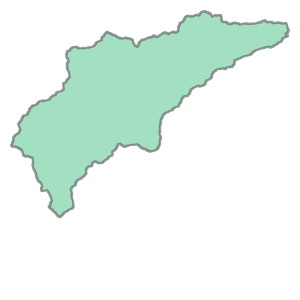

In [22]:
watershed.exterior()

A wide range of data sources are available; here we use the defaults except for using NHD Plus for watershed boundaries and hydrography (the default is NHD, which is lower resolution and therefore smaller download sizes).

In [23]:
# set up a dictionary of source objects
sources = workflow.source_list.get_default_sources()
sources['hydrography'] = workflow.source_list.hydrography_sources['NHD Plus']
sources['HUC'] = workflow.source_list.huc_sources['NHD Plus']
# use 10-m DEM instead
sources['DEM'] = workflow.source_list.dem_sources['NED 1/3 arc-second']
workflow.source_list.log_sources(sources)

2022-11-29 15:28:34,397 - root - INFO: Using sources:
2022-11-29 15:28:34,397 - root - INFO: --------------
2022-11-29 15:28:34,398 - root - INFO: HUC: National Hydrography Dataset Plus High Resolution (NHDPlus HR)
2022-11-29 15:28:34,398 - root - INFO: hydrography: National Hydrography Dataset Plus High Resolution (NHDPlus HR)
2022-11-29 15:28:34,398 - root - INFO: DEM: National Elevation Dataset (NED)
2022-11-29 15:28:34,399 - root - INFO: soil structure: National Resources Conservation Service Soil Survey (NRCS Soils)
2022-11-29 15:28:34,399 - root - INFO: geologic structure: GLHYMPS version 2.0
2022-11-29 15:28:34,400 - root - INFO: land cover: National Land Cover Database (NLCD) Layer: NLCD_2016_Land_Cover_L48
2022-11-29 15:28:34,400 - root - INFO: soil thickness: None
2022-11-29 15:28:34,401 - root - INFO: meteorology: DayMet 1km


## Generate the surface mesh

First we'll generate the flattened, 2D triangulation, which builds on hydrography data.  Then we download a digital elevation map from the National Elevation Dataset, and extrude that 2D triangulation to a 3D surface mesh based on interpolation between pixels of the DEM.

## import river shapes

In [24]:
simplify = 50 # unit in crs, this may be useful to smooth both river segments and huc boundary

with open("../data/WW_outputs/ARW_rivers_ignore2_prune1_simplify50.p", "rb") as f:
    rivers = pickle.load(f)
    
workflow.split_hucs.simplify(watershed, simplify)

In [ ]:
# # find what HUC our shape is in
# huc = workflow.find_huc(sources['HUC'], watershed.exterior(), crs, hint = '1703', shrink_factor=0.1)
# logging.info("Found watershed in HUC: {}".format(huc))

In [ ]:
# huc = "1703000201" # provide the HUC8 for NHD or HUC4 for NHDPlus that includes that watershed
# simplify = 50 # unit in crs, this may be useful to smooth both river segments and huc boundary

# rivers = True
# if rivers:
#     # download/collect the river network within that shape's bounds
#     _, reaches = workflow.get_reaches(sources['hydrography'], huc, 
#                                       watershed.exterior().bounds, crs)
#     # simplify and prune rivers not IN the shape, constructing a tree-like data structure
#     # for the river network
#     rivers = workflow.simplify_and_prune(watershed, reaches, filter=True, simplify=simplify, 
#                                          cut_intersections=True,
#                                         ignore_small_rivers=2, prune_by_area_fraction=0.01
#                                         )

# else:
#     rivers = list()
#     workflow.split_hucs.simplify(watershed, simplify)



In [23]:
# with open("./results/ARW_rivers_ignore2_prune1_simplify50.p", "wb") as f:
#     pickle.dump(rivers, f, protocol=-1)

### plot watershed bnd and river networks

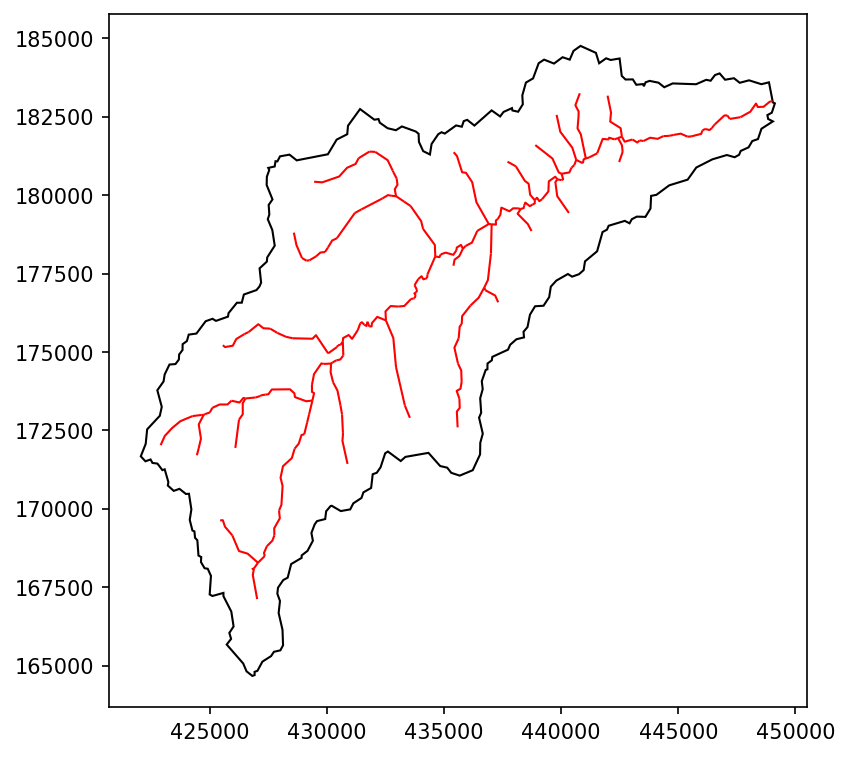

In [25]:
# plot what we have so far -- an image of the HUC and its stream network
fig,ax = plt.subplots(1,1, figsize=(6,6))
# ax = workflow.plot.get_ax(crs, fig)

workflow.plot.hucs(watershed, crs, ax=ax, color='k', linewidth=1)
workflow.plot.rivers(rivers, crs, ax=ax, color='red', linewidth=1)

plt.show()

2022-11-29 15:28:45,993 - root - INFO: 
2022-11-29 15:28:45,994 - root - INFO: Meshing
2022-11-29 15:28:45,994 - root - INFO: ------------------------------
2022-11-29 15:28:46,004 - root - INFO: Triangulating...
2022-11-29 15:28:46,006 - root - INFO:    257 points and 257 facets
2022-11-29 15:28:46,006 - root - INFO:  checking graph consistency
2022-11-29 15:28:46,006 - root - INFO:  tolerance is set to 1
2022-11-29 15:28:46,008 - root - INFO:  building graph data structures
2022-11-29 15:28:46,009 - root - INFO:  triangle.build...
2022-11-29 15:28:46,010 - root - WARNING: Triangulate: '--enforce-delaunay' option requires a hacked `meshpy.triangle`.  Proceeding without this option because it is not recognized.
2022-11-29 15:29:08,911 - root - INFO:   ...built: 4101 mesh points and 7854 triangles
2022-11-29 15:29:08,911 - root - INFO: Plotting triangulation diagnostics
2022-11-29 15:29:09,540 - root - INFO:   min area = 2436.565872192383
2022-11-29 15:29:09,541 - root - INFO:   max are

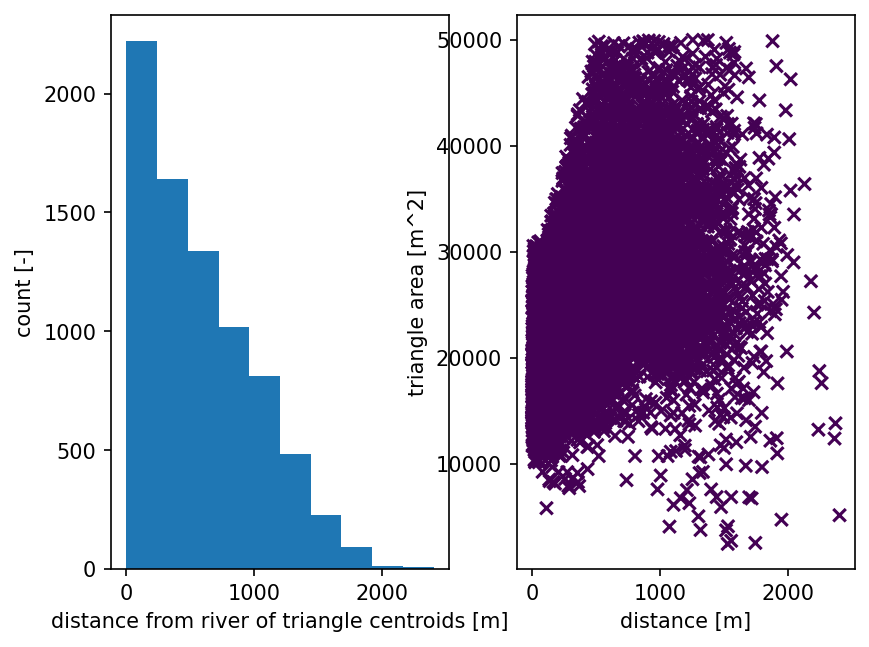

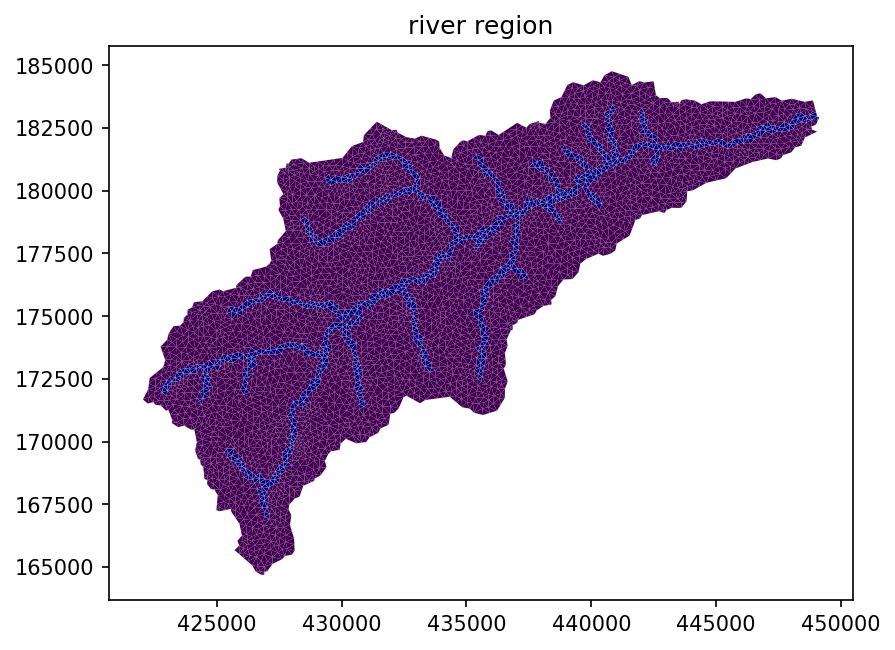

In [26]:
# form a triangulation on the shape + river network

# triangulation refinement:
# Refine triangles if their area (in m^2) is greater than A(d), where d is the 
# distance from the triangle centroid to the nearest stream.
# A(d) is a piecewise linear function -- A = A0 if d <= d0, A = A1 if d >= d1, and
# linearly interpolates between the two endpoints.

# d0 = 10; d1 = 100
d0 = 100; d1 = 500

# A0 = 1250; A1 = 50000 # [50, 310]m
A0 = 31250; A1 = 50000 # [250, 310]m
# A0 = 50000; A1 = 50000 # [~310, 310]m

# Refine triangles if they get too acute
min_angle = 32 # degrees

# make 2D mesh
mesh_points2, mesh_tris, areas, distances, river_idx = workflow.triangulate(watershed, rivers,                                                 
                                               refine_distance=[d0,A0,d1,A1],
                                               refine_min_angle=min_angle,
                                               enforce_delaunay=True,
                                               diagnostics=True,
                                                river_region_dist = 125)

In [184]:
np.savetxt(fname_river_idx, river_idx, fmt='%1d')

In [170]:
with open(fname_2Dmesh, "wb") as f:
    pickle.dump((mesh_points2, mesh_tris, areas, distances, river_idx), f, protocol=-1)

## Download DEM

In [27]:
# get a raster for the elevation map, based on NED
dem_profile, dem = workflow.get_raster_on_shape(sources['DEM'], watershed.exterior(), crs
                                                 )

2022-11-29 15:29:10,082 - root - INFO: 
2022-11-29 15:29:10,083 - root - INFO: Loading Raster
2022-11-29 15:29:10,083 - root - INFO: ------------------------------
2022-11-29 15:29:10,084 - root - INFO: Collecting raster
2022-11-29 15:29:10,122 - root - INFO: Collecting DEMs to tile bounds: [-121.53267188195281, 46.80084247630872, -121.15868167776584, 47.002974902927264]
2022-11-29 15:29:10,123 - root - INFO:   Need:
2022-11-29 15:29:10,124 - root - INFO:     /Users/shuai/github/watershed-workflow/data_library/dem/USGS_NED_13as_n47_w122.tif
2022-11-29 15:29:10,124 - root - INFO:     /Users/shuai/github/watershed-workflow/data_library/dem/USGS_NED_13as_n48_w122.tif
2022-11-29 15:29:10,124 - root - INFO: source files already exist!
2022-11-29 15:29:10,622 - root - INFO: ... got raster of shape: (2183, 4039)
2022-11-29 15:29:10,624 - root - INFO: ... got raster bounds: (-121.53267188195281, 47.002974902927264, -121.158690400069, 46.800845273080185)


Smooth DEM if DEM-res is larger than average mesh-res, and there is artifical pits.

Text(0.5, 1.0, 'smoothed')

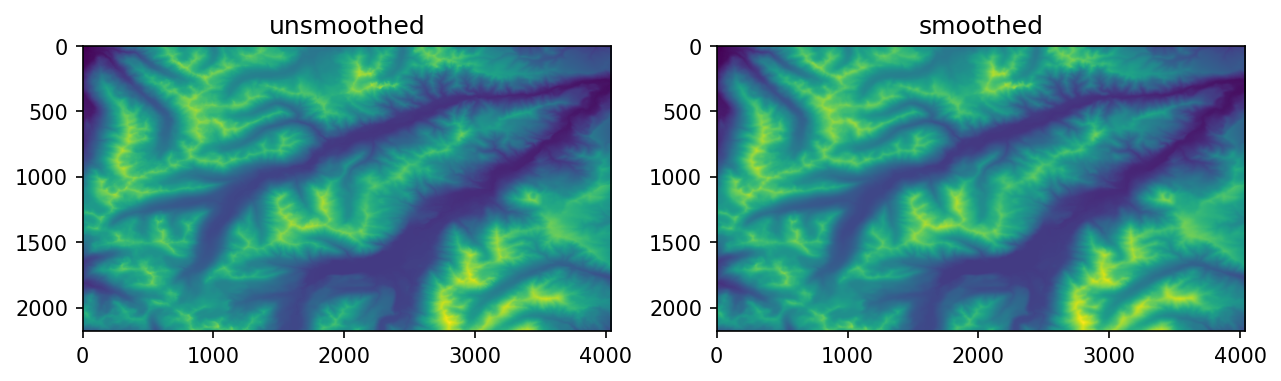

In [28]:
# noting that the DEM is a 30m raster, and we want to run at a coarser resolution of ~100-300m, 
# the DEM will look quite rough.  Smooth a small amount.  Note better algorithms could be used 
# here, but for now we just use Gaussian smoothing.
dem_sm = scipy.ndimage.gaussian_filter(dem, 3, mode='nearest')

fig, axs = plt.subplots(1,2, figsize=(10,5))
axs[0].imshow(dem)
axs[0].set_title('unsmoothed')

axs[1].imshow(dem_sm)
axs[1].set_title('smoothed')


In [29]:
np.min(dem), np.max(dem)

(785.9692, 2300.5635)

In [30]:
np.min(dem_sm), np.max(dem_sm)

(786.5281, 2284.1204)

### Map mesh to DEM

In [31]:
# elevate the triangle nodes to the dem
mesh_points3 = workflow.elevate(mesh_points2, crs, dem_sm, dem_profile)

2022-11-29 15:29:18,930 - root - INFO: 
2022-11-29 15:29:18,931 - root - INFO: Elevating Triangulation to DEM
2022-11-29 15:29:18,931 - root - INFO: ------------------------------


Plotting the resulting mesh can be done in a variety of ways, including both 3D plots and mapview.  We show both here, but hereafter use mapview plots as they are a bit clearer (if not so flashy)...

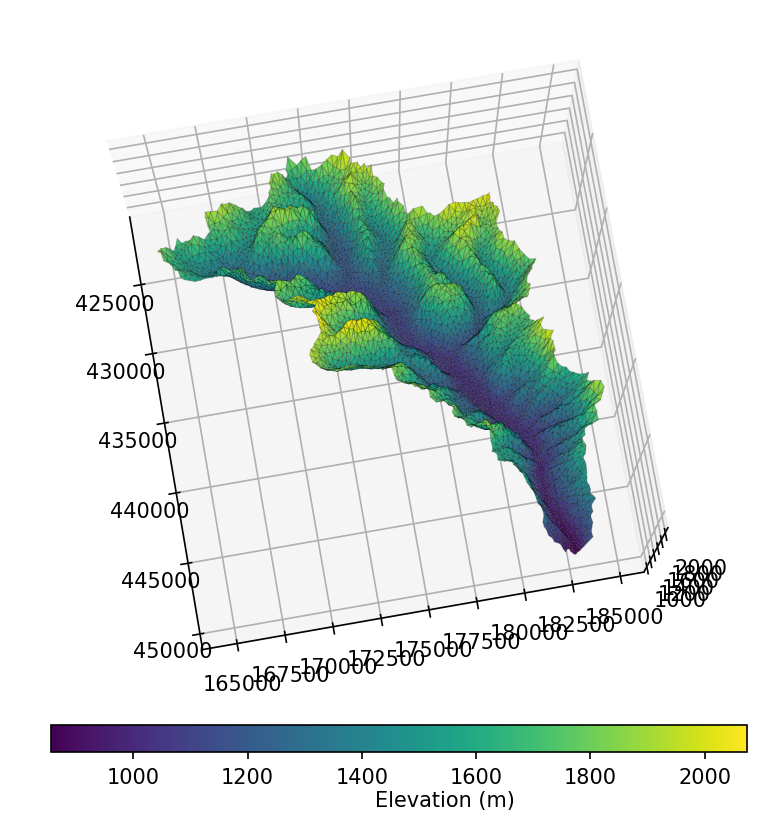

In [19]:
# plot the resulting surface mesh
fig = plt.figure(figsize=figsize_3d)
ax = workflow.plot.get_ax('3d', fig, window=[0.0,0.2,1,0.8])
cax = fig.add_axes([0.23,0.18,0.58,0.03])

mp = ax.plot_trisurf(mesh_points3[:,0], mesh_points3[:,1], mesh_points3[:,2], 
                     triangles=mesh_tris, cmap='viridis', 
                     edgecolor=(0,0,0,.2), linewidth=0.5)
cb = fig.colorbar(mp, orientation="horizontal", cax=cax)

# t = cax.set_title('elevation [m]')
plt.text(0.5, -0.1, 'Elevation (m)', transform=ax.transAxes)

ax.view_init(80,-10)
# ax.set_xticklabels(list())
# ax.set_yticklabels(list())

# fig.savefig(fig_mesh3D, dpi = 300, transparent= True)

(420690.907869218, 450480.01055056666)
(162304.8413827714, 187129.09361722865)


/Users/shuai/opt/anaconda3/envs/watershed_workflow-2022-08-29/lib/python3.10/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


Text(0, 0.5, 'Elevation [m]')

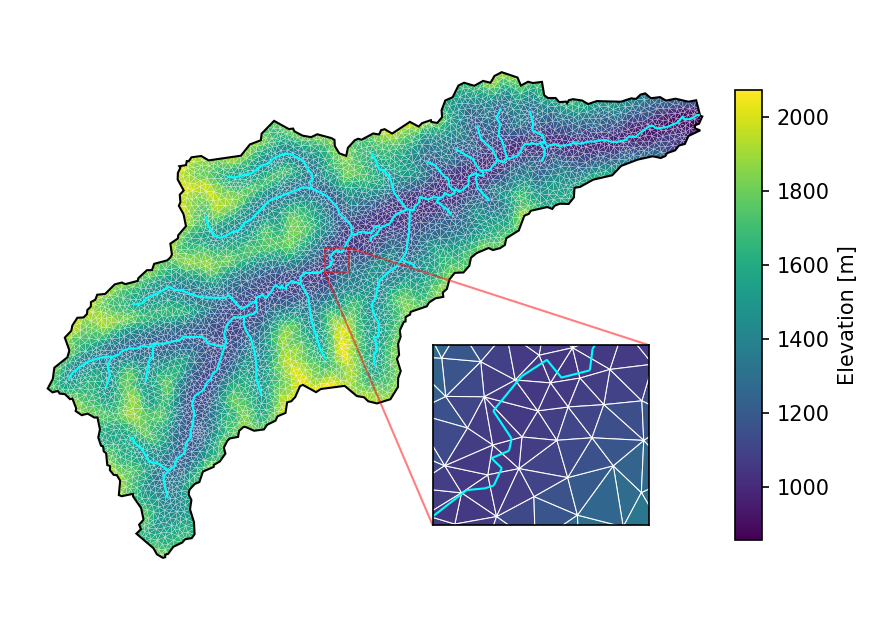

In [32]:
# plot the resulting surface mesh
fig = plt.figure(figsize=(6,5))
ax = workflow.plot.get_ax(crs, fig, window=[0.05,0.1,0.8,0.8])
#ax2 = workflow.plot.get_ax(crs,fig, window=[0.65,0.05,0.3,0.5])
ax2 = ax.inset_axes([0.58,0.15,0.3,0.3])
# cbax = fig.add_axes([0.05,0.05,0.9,0.05])
cbax = fig.add_axes([.85,0.2,0.03,0.6])

bxlim = (433500, 434500)
bylim = (176500., 177500.)

mp = workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax, 
                                 color='elevation', edgecolor='white', linewidth=0.1)
cbar = fig.colorbar(mp, orientation="vertical", cax=cbax)
workflow.plot.hucs(watershed, crs, ax=ax, color='k', linewidth=1)
workflow.plot.rivers(rivers, crs, ax=ax, color='aqua', linewidth=1)
ax.set_aspect('equal', 'datalim')
# ax.set_xlim([770000, 800000])
# ax.set_ylim([4520000, 4550000])

mp2 = workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax2, 
                                 color='elevation', edgecolor='white', linewidth=0.5)
workflow.plot.hucs(watershed, crs, ax=ax2, color='k', linewidth=1)
workflow.plot.rivers(rivers, crs, ax=ax2, color='aqua', linewidth=1.)
ax2.set_xlim(bxlim)
ax2.set_ylim(bylim)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_aspect('equal', 'datalim')

ax.indicate_inset_zoom(ax2, edgecolor='r')

# ax.margins(0.5)
ax.axis('off')
# add scalebar, use 1 for UTM coordinates, the default unit is "m"
# scalebar1 = ScaleBar(1, location = "lower left")
# ax.add_artist(scalebar1)
# scalebar2 = ScaleBar(1, location = "upper right")

# ax2.add_artist(scalebar2)

print(ax.get_xlim())
print(ax.get_ylim())
cbar.ax.set_ylabel('Elevation [m]')

# fig.tight_layout()
# fig.savefig(fig_mesh, dpi = 300)

In [33]:
fig.savefig("../figures/riverbed_study/mesh_250m.jpg", dpi=300)
plt.close(fig)

In [18]:
# with open(fname_mesh_pickle, 'wb') as f:
#     pickle.dump((mesh_points3, mesh_points2, mesh_tris), f, protocol=-1)

### construct 2d mesh 

In [112]:
# with open(fname_mesh_pickle, 'rb') as f:
#     mesh_points3, mesh_points2, mesh_tris = pickle.load(f)

In [22]:
# construct the 2D mesh
m2 = workflow.mesh.Mesh2D(mesh_points3.copy(), list(mesh_tris))

### Hydrologically condition the mesh

2022-03-22 14:41:42,167 - root - INFO: max diff = 74.33883044261756 


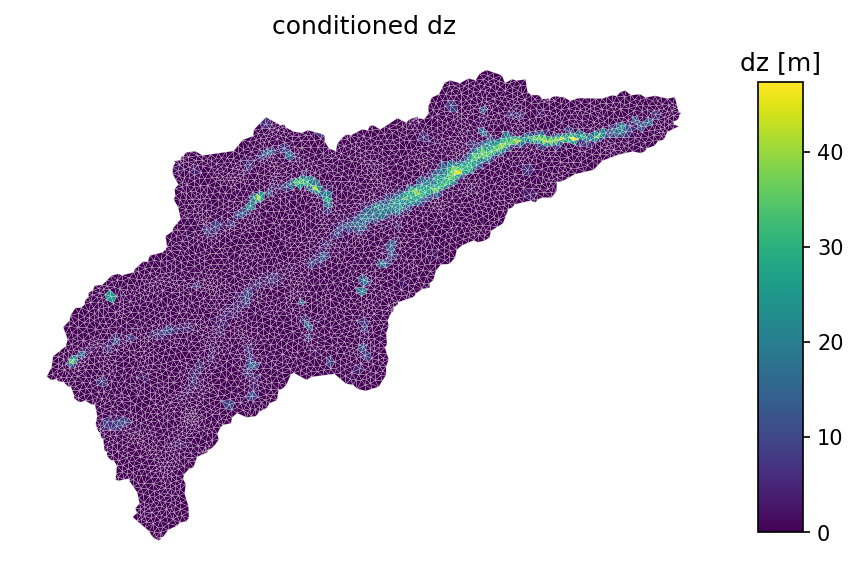

In [23]:
# hydrologically condition the mesh
# workflow.condition.condition(m2)
workflow.condition.fill_pits_dual(m2)

# plot the change between the two meshes
diff = np.copy(mesh_points3)
diff[:,2] = m2.coords[:,2] - mesh_points3[:,2] 
logging.info(f"max diff = {np.abs(diff[:,2]).max()} ")
fig, ax = workflow.plot.get_ax(crs, figsize=figsize)
cbax = fig.add_axes([.95,0.25,0.05,0.5])

mp = workflow.plot.triangulation(diff, m2.conn, crs, color='elevation', edgecolors='white', 
                            linewidth=0.1, ax=ax)
cbar = fig.colorbar(mp, orientation="vertical", cax=cbax)
cbar.ax.set_title('dz [m]')
ax.axis('off')
ax.set_title('conditioned dz')
plt.show()

### Export surface mesh

In [115]:
# m2.write_VTK(fname_surface_mesh)

## Surface properties

Meshes interact with data to provide forcing, parameters, and more in the actual simulation.  Specifically, we need vegetation type on the surface to provide information about transpiration and subsurface structure to provide information about water retention curves, etc.

We'll start by downloading and collecting land cover from the NLCD dataset, and generate sets for each land cover type that cover the surface.  Likely these will be some combination of grass, deciduous forest, coniferous forest, and mixed.

In [119]:
# m2 = workflow.mesh.Mesh2D.read_VTK(fname_surface_mesh)

In [31]:
# download the NLCD raster
lc_profile, lc_raster = workflow.get_raster_on_shape(sources['land cover'],
                                                     watershed.exterior(), crs,
                                                     )

# resample the raster to the triangles
lc = workflow.values_from_raster(m2.centroids(), crs, lc_raster, lc_profile)

# what land cover types did we get?
logging.info('Found land cover dtypes: {}'.format(lc.dtype))
logging.info('Found land cover types: {}'.format(set(lc)))


2022-03-22 15:14:02,552 - root - INFO: 
2022-03-22 15:14:02,552 - root - INFO: Loading Raster
2022-03-22 15:14:02,553 - root - INFO: ------------------------------
2022-03-22 15:14:02,553 - root - INFO: Collecting raster
2022-03-22 15:14:02,565 - root - INFO: CRS: PROJCS["Albers_Conical_Equal_Area",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["meters",1],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
2022-03-22 15:14:02,730 - root - INFO: ... got raster of shape: (542, 973)
2022-03-22 15:14:02,741 - root - INFO: ... got raster bounds:

In [32]:
# -- get the NLCD colormap which uses official NLCD colors and labels
nlcd_indices, nlcd_cmap, nlcd_norm, nlcd_ticks, nlcd_labels = \
                workflow.colors.generate_nlcd_colormap(lc)

In [33]:
area_list = [areas[lc==i].sum() for i in nlcd_indices]
area_coverage = np.array(area_list) / areas.sum() * 100

nlcd_df = pd.DataFrame([nlcd_indices, nlcd_labels, area_list]).T
nlcd_df.columns = ['id', 'name', 'area']
nlcd_df.set_index('id', inplace = True)

nlcd_df['coverage [%]'] = area_coverage

# nlcd_df.to_csv(fname_nlcd_prop)

(420690.90789999993, 450480.0101, 163665.86095, 185768.07405000002)

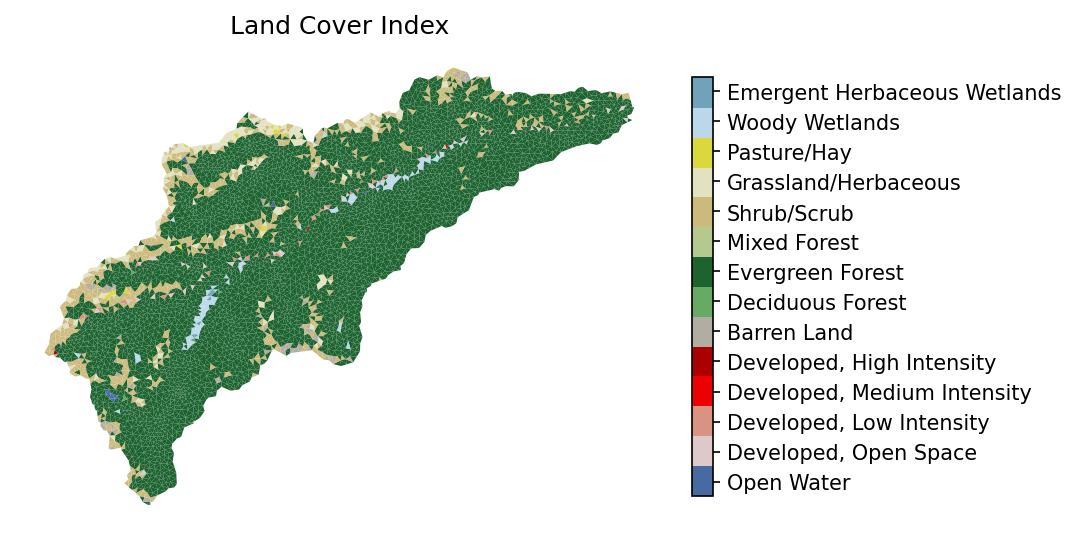

In [34]:
# plot the image
fig = plt.figure(figsize=figsize)
ax = workflow.plot.get_ax(crs, fig)

polys = workflow.plot.mesh(m2, crs, ax=ax, color=lc, cmap=nlcd_cmap, norm=nlcd_norm, edgecolor='none', 
                                     facecolor='color', linewidth=0.5)

workflow.colors.colorbar_index(ncolors=len(np.unique(lc)), cmap=nlcd_cmap, labels = nlcd_labels) 

ax.set_title("Land Cover Index")
ax.axis('off')
# fig.tight_layout()
# fig.savefig(fig_land_cover, dpi = 300, transparent = True)

In [30]:
# # we don't really need all of these.  Keep Evergreen, Deciduous, Shrub, and merge the rest into "Other"
# nlcd_color_new = 99 * np.ones_like(lc)

# groupings = {
#     42 : ['Evergreen Forest',],
#     41 : ['Deciduous Forest', 'Mixed Forest', 'Woody Wetlands'],
#     52 : ['Dwarf Scrub', 'Shrub/Scrub', 'Grassland/Herbaceous', 'Sedge/Herbaceous', 
#                      'Pasture/Hay', 'Cultivated Crops'],
# }

# for k,v in groupings.items():
#     for label in v:
#         index = sources['land cover'].indices[label]
#         nlcd_color_new[np.where(lc == index)] = k
    
# print(nlcd_color_new)

# # plot the updated image, adding "other"
# nlcd_color_new_other_as_water = np.where(nlcd_color_new == 99, 11, nlcd_color_new)

# # -- get the NLCD colormap which uses official NLCD colors and labels
# nlcd_indices, nlcd_cmap, nlcd_norm, nlcd_ticks, nlcd_labels = \
#                 workflow.colors.generate_nlcd_colormap(nlcd_color_new_other_as_water)

# # make (water, 11) into (other, 99)
# nlcd_labels[0] = 'Other'
# nlcd_indices[0] = 99

# fig, ax = workflow.plot.get_ax(crs)


# polys = workflow.plot.mesh(m2, crs, ax=ax, color=nlcd_color_new_other_as_water, 
#                            cmap=nlcd_cmap, norm=nlcd_norm, edgecolor='none', 
#                         facecolor='color', linewidth=0.5)

# workflow.colors.colorbar_index(ncolors=len(np.unique(nlcd_color_new_other_as_water)), 
#                                cmap=nlcd_cmap, labels = nlcd_labels) 

# ax.set_title("Land Cover Index")
# ext = ax.axis('off')
# # fig.savefig(out_dir + f'{name}_land_cover')

In [35]:
# add labeled sets to the mesh for NLCD
nlcd_labels_dict = dict(zip(nlcd_indices, nlcd_labels))
# watershed_workflow.mesh.add_nlcd_labeled_sets(m2, nlcd_color_new, nlcd_labels_dict)
with open(f"../data/WW_outputs/{watershed_name}_nlcd_{meshRes}.p", "wb") as f:
    pickle.dump(nlcd_labels_dict, f, protocol=-1)

## Subsurface properties

In [41]:
# download the NRCS soils data as shapes and project it onto the mesh
import matplotlib.cm

# -- download the shapes
target_bounds = watershed.exterior().bounds
logging.info('target bounds: {}'.format(target_bounds))
_, soil_survey, soil_survey_props = workflow.get_shapes(sources['soil structure'], target_bounds, crs, crs,
                                                        properties=True
                                                       )
# _, soil_survey, soil_survey_props = workflow.get_shapes(fname_soil, target_bounds, crs, crs,
#                                                         properties=True
#                                                        )

# -- determine the NRCS mukey for each soil unit; this uniquely identifies soil 
#    properties
soil_ids = np.array([shp.properties['mukey'] for shp in soil_survey], np.int32)

# -- color a raster by the polygons (this makes identifying a triangle's value much 
#    more efficient)
soil_color_raster, soil_color_profile, img_bounds = \
            workflow.color_raster_from_shapes(target_bounds, 10, soil_survey,
                                              soil_ids, crs)

# -- resample the raster to the triangles
soil_color = workflow.values_from_raster(m2.centroids(), crs, 
                                         soil_color_raster, soil_color_profile)

2022-03-23 14:01:19,903 - root - INFO: target bounds: (422044.9579910975, 164670.50734242608, 449125.96042868716, 184763.42768634777)
2022-03-23 14:01:19,903 - root - INFO: 
2022-03-23 14:01:19,904 - root - INFO: Loading shapes
2022-03-23 14:01:19,904 - root - INFO: ------------------------------
2022-03-23 14:01:20,117 - root - INFO: Attempting to download source for target '/Users/shua784/github/watershed-workflow/data_library/soil_structure/SSURGO/SSURGO_-121.5250_46.8102_-121.1666_46.9938.shp'
2022-03-23 14:01:20,293 - root - INFO:   Found 911 shapes.
2022-03-23 14:01:20,313 - root - INFO:   and crs: +init=epsg:4326 +type=crs
2022-03-23 14:01:20,374 - root - INFO: found 137 unique MUKEYs.
2022-03-23 14:01:27,004 - root - INFO: Running Rosetta for van Genutchen parameters
2022-03-23 14:01:27,004 - root - INFO:   database: /Users/shua784/github/watershed-workflow/workflow_tpls/rosetta/sqlite/Rosetta.sqlite
2022-03-23 14:01:27,005 - root - INFO:   model type: 3
2022-03-23 14:01:27,231

In [42]:
soil_survey_props.set_index('mukey', inplace=True, drop=False)
# only select soils that are mapped to the meshes
soil_survey_props = soil_survey_props.loc[np.unique(soil_color), :]
soil_survey_props

residual saturation [-]  Rosetta porosity [-]  \
mukey                                                    
75322                   0.145075              0.499499   
75327                   0.144439              0.503187   
75328                   0.144439              0.503187   
75334                   0.142051              0.544058   
75339                   0.146170              0.483327   
75340                   0.146170              0.483327   
75342                   0.146170              0.483327   
75343                   0.151733              0.480084   
75349                   0.146170              0.483327   
75351                   0.143734              0.486791   
75352                   0.146170              0.483327   
75356                   0.237882              0.450137   
75357                   0.157105              0.491984   
75359                   0.157105              0.491984   
75361                   0.157105              0.491984   
75392                   0.159837              0.399205   
75394                   0.169375              0.668827   
75398                   0.190480              0.439748   
75403                   0.165622              0.458559   
75404                   0.185394              0.468879   
75413                   0.175752              0.465846   
75414                   0.183089              0.468944   
75440                   0.139917              0.537325   
75462                   0.141032              0.487731   
75482                   0.141032              0.487731   
75485                   0.141032              0.487731   
75506                   0.146160              0.540057   
75508                   0.146160              0.540057   
75511                   0.146160              0.540057   
75514                   0.138221              0.533100   
75572                   0.196534              0.452128   
75586                   0.191737              0.464576   
75618                   0.137973              0.355435   
75654                   0.152045              0.508401   
75661                   0.142668              0.501073   
75670                   0.142668              0.501073   
75691                        NaN                   NaN   
75693                        NaN                   NaN   
75694                   0.146170              0.483327   
75695                   0.157105              0.491984   
75696                   0.150562              0.493175   
679189                       NaN                   NaN   
2756442                 0.135787              0.449059   
2901079                 0.137329              0.467624   
2901080                 0.136530              0.419020   
2901081                 0.135787              0.449059   
2901082                 0.135705              0.453385   
2901083                 0.134198              0.476149   
2901084                 0.138696              0.470192   
2901085                 0.136183              0.469465   
2901086                 0.137720              0.472292   

         van Genuchten alpha [Pa^-1]  van Genuchten n [-]  \
mukey                                                       
75322                       0.000109             1.499192   
75327                       0.000058             1.522258   
75328                       0.000058             1.522258   
75334                       0.000100             1.464120   
75339                       0.000083             1.507824   
75340                       0.000083             1.507824   
75342                       0.000083             1.507824   
75343                       0.000079             1.499234   
75349                       0.000083             1.507824   
75351                       0.000094             1.508879   
75352                       0.000083             1.507824   
75356                       0.000062             1.378550   
75357                       0.000126             1.483837   
75359              

In [43]:
area_list = [areas[soil_color==i].sum() for i in np.unique(soil_color)]
assert(np.sum(area_list) == areas.sum())
area_coverage = np.array(area_list) / areas.sum() * 100

# soil_survey_props.set_index('mukey', inplace = True)
# sub_soil_props = soil_survey_props.loc[unique_soil_id,:]
soil_id_df = pd.DataFrame(np.array(np.unique(soil_color, return_counts=True)).T, columns = ['mukey', 'count'])
soil_id_df.set_index('mukey', inplace = True)
soil_id_df['area'] = area_list
soil_id_df['coverage [%]'] = area_coverage

soil_prop_df = soil_survey_props.merge(soil_id_df, how = 'inner', left_index = True, right_index = True, sort = True)
# soil_prop_df.to_csv(fname_soil_prop)

/opt/anaconda3/envs/workflow-021121/lib/python3.9/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()


(420690.90789999993, 450480.0101, 163665.86095, 185768.07405000002)

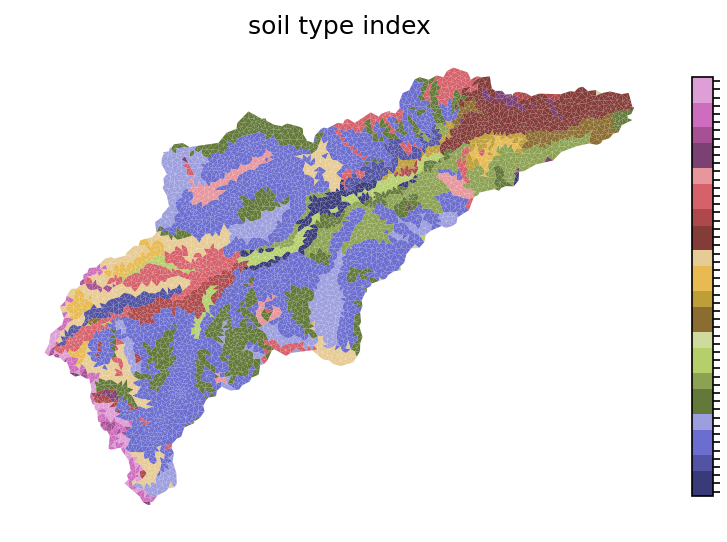

In [44]:
indices, cmap, norm, ticks, labels = workflow.colors.generate_indexed_colormap(soil_color, cmap = 'tab20b')

# plot the soil mukey
fig = plt.figure(figsize=figsize)
ax = workflow.plot.get_ax(crs, fig)

mp = workflow.plot.mesh(m2, crs, ax=ax, facecolor='color',
                        linewidth=0, color=soil_color, 
                        cmap=cmap, norm = norm
                       )

workflow.colors.colorbar_index(ncolors=len(np.unique(soil_color)), cmap=cmap, labels = '', fraction = 0.03) 

ax.set_title('soil type index')
ax.axis('off')
# fig.savefig('watershed_soils')

/opt/anaconda3/envs/workflow-021121/lib/python3.9/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()


(420690.90789999993, 450480.0101, 163665.86095, 185768.07405000002)

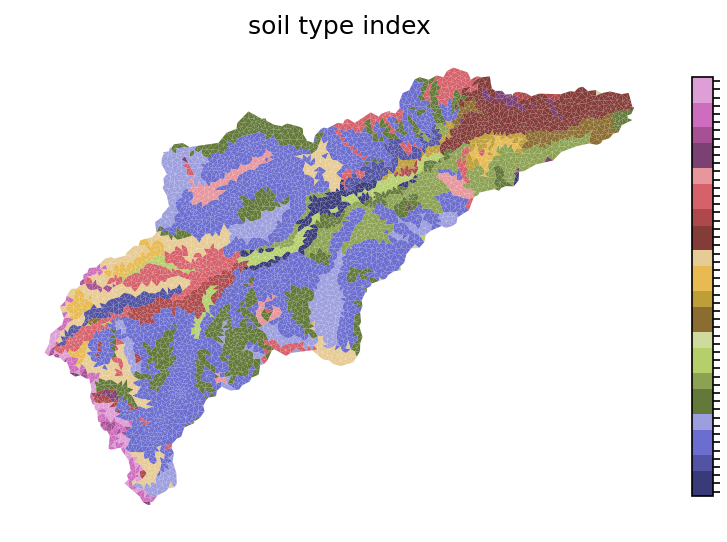

Median soil thickness [m] =  nan


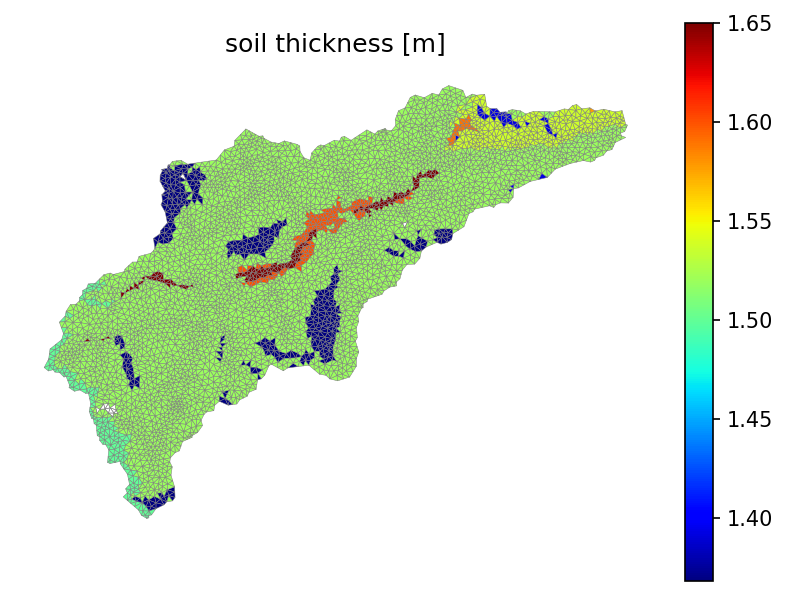

In [79]:
# what do soil thicknesses look like?
fig = plt.figure(figsize=figsize)
iprop = np.empty(soil_color.shape, 'd')
for mukey in soil_survey_props.index:
    iprop[soil_color == mukey] = soil_survey_props.loc[ mukey,'thickness [cm]']

ax = workflow.plot.get_ax(crs, fig)
mp = workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax, 
                                 color=iprop/100, edgecolor='gray', cmap='jet')
# cbar = fig.colorbar(mp)
ax.set_title('soil thickness [m]')
cb = fig.colorbar(mp, fraction=0.04, pad=0.04)
# cb.ax.set_title('[m]')
# cb.set_ticks(nlcd_ticks)
# cb.set_ticklabels(nlcd_labels_fw)
# ax.set_title("Land Cover Index")
ax.axis('off')

print('Median soil thickness [m] = ', np.median(iprop)/100)

# fig.savefig('watershed_soil_thickness')


Median soil thickness [m] =  0.4123684210526316


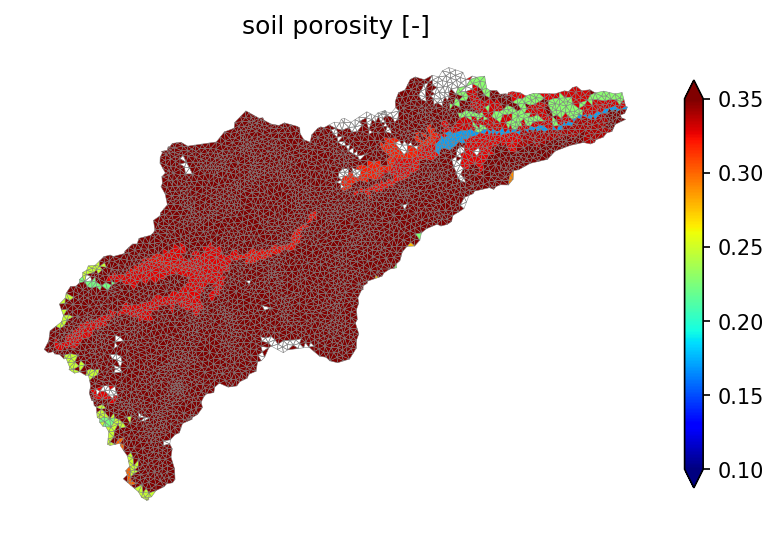

In [80]:
# what do soil thicknesses look like?
fig = plt.figure(figsize=figsize)
iprop = np.empty(soil_color.shape, 'd')
for mukey in soil_survey_props.index:
    iprop[soil_color == mukey] = soil_survey_props.loc[ mukey,'porosity [-]']

ax = workflow.plot.get_ax(crs, fig)
mp = workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax, 
                                 color=iprop, edgecolor='gray', cmap='jet', vmin = 0.1, vmax = 0.35)
# cbar = fig.colorbar(mp)
ax.set_title('soil porosity [-]')
cb = fig.colorbar(mp, fraction=0.04, pad=0.04, extend = "both", shrink = 0.6)
# cb.ax.set_title('[m]')
# cb.set_ticks(nlcd_ticks)
# cb.set_ticklabels(nlcd_labels_fw)
# ax.set_title("Land Cover Index")
ax.axis('off')

print('Median soil thickness [m] = ', np.nanmedian(iprop))

# fig.savefig('watershed_soil_thickness')


Min k [m^2] =  2.0937843947447842e-13


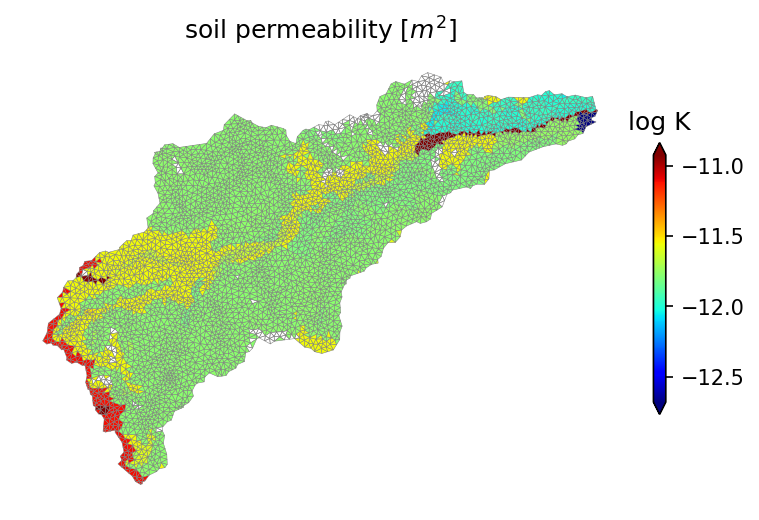

In [45]:
# plot of permeability
iprop = np.empty(soil_color.shape, 'd')
for mukey in soil_survey_props.index:
    iprop[soil_color == mukey] = soil_survey_props.loc[ mukey,'permeability [m^2]']

fig, ax = workflow.plot.get_ax(crs)
mp = workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax, 
                                 color=np.log10(iprop), edgecolor='gray', cmap='jet')
ax.set_title('soil permeability [$m^2$]')
cb = fig.colorbar(mp, fraction=0.04, pad=0.04, extend = "both", shrink = 0.6)
cb.ax.set_title('log K')
ax.axis('off')

print('Min k [m^2] = ', np.nanmin(iprop))

Min k [m^2] =  2.0937843947447842e-13


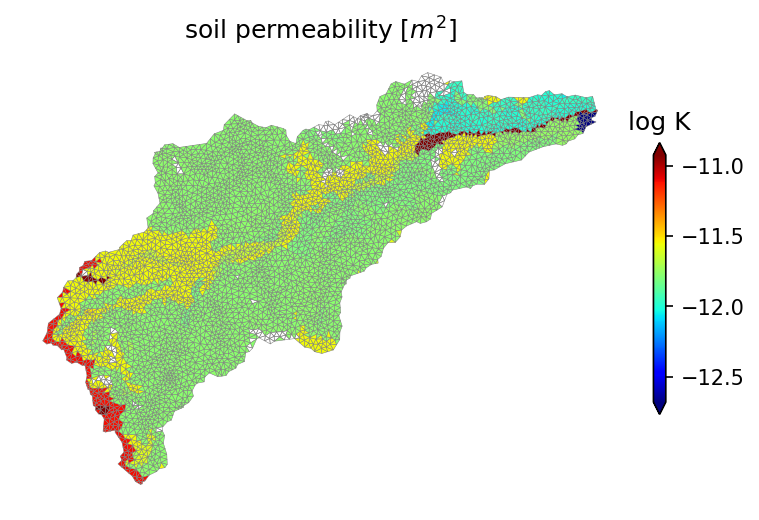

In [50]:
orig_soil_prop_df = pd.read_csv("../data/WW_outputs/American_soil_prop-250m-riverbed.csv", index_col=0)

In [53]:
soil_prop_df.equals(orig_soil_prop_df)

False

In [171]:
orig_soil_prop_df.shape, soil_prop_df.shape 

((52, 17), (51, 21))

In [58]:
orig_soil_prop_df.index.difference(soil_prop_df.index)

Int64Index([75318], dtype='int64', name='mukey')

### gap filled

In [62]:
def gapfill_soil(soil_prop):
    #replace null values in soil properties with the dominant soil type
    cols = ['residual saturation [-]', 'van Genuchten alpha [Pa^-1]','van Genuchten n [-]', 'permeability [m^2]', 'porosity [-]']
    if soil_prop[cols].isnull().any().any():
        null_soil_id = soil_prop.index[soil_prop[cols].isnull().any(1)]
        logging.debug(f'found soil ids without property: {null_soil_id}')
        soil_id_max = soil_prop.index[soil_prop['coverage [%]'].argmax()]
        logging.debug(f'null soil ids property will be replaced with that of the dominant soil id: {soil_id_max}')
        if not soil_prop.loc[soil_id_max, cols].isnull().any():
            soil_prop.loc[null_soil_id, cols] = soil_prop.loc[soil_id_max, cols].values.reshape(1, -1)
        else:
            raise ValueError('the dominant soil type has null property! replace it with the next dominant type!')

    assert(soil_prop[cols].isnull().values.any() == False)
    
    return soil_prop

In [66]:
soil_prop_df = gapfill_soil(soil_prop_df)

### k-mean clustering

We use K-mean clustering to group soil into different groups based on permeability values. Everytime when executing the k-mean clustering, the group # will change randomly. To allow consistency, we fix the order of the clustering using pre-determined clusters.

In [22]:
# soil_prop_df = pd.read_csv("/Users/shua784/github/yakima/data/material/American_soil_prop-250m-riverbed-gapfill-clustered.csv",
#                           index_col='mukey'
#                           )

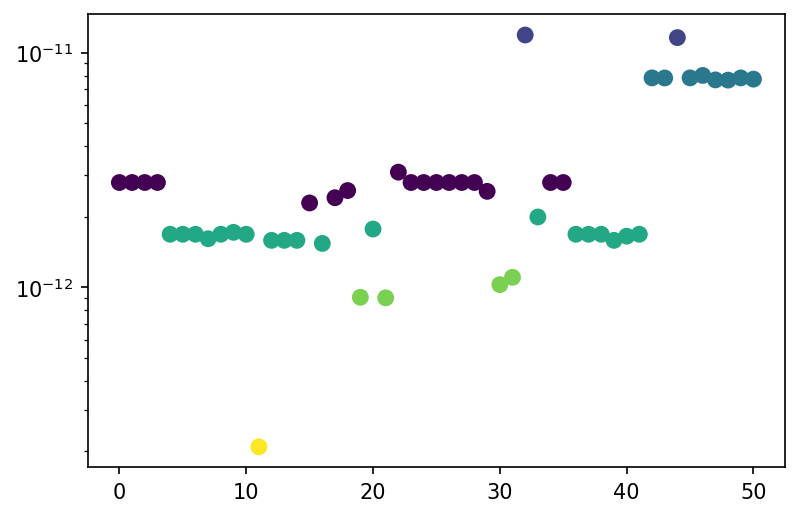

In [71]:
kmeans = KMeans(n_clusters=6) # vary number of clusters to tweak results
X= soil_prop_df['permeability [m^2]'].values.reshape(-1, 1)
kmeans.fit(X)
y_kmeans = kmeans.predict(X) # the group will change randomly?

plt.scatter(np.arange(X.shape[0]), X[:, 0], c=y_kmeans, s=50, cmap='viridis')
plt.yscale('log')
# centers = kmeans.cluster_centers_
# plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

cluster = y_kmeans + 1 # convert to 1-based index
soil_prop_df['cluster'] = cluster

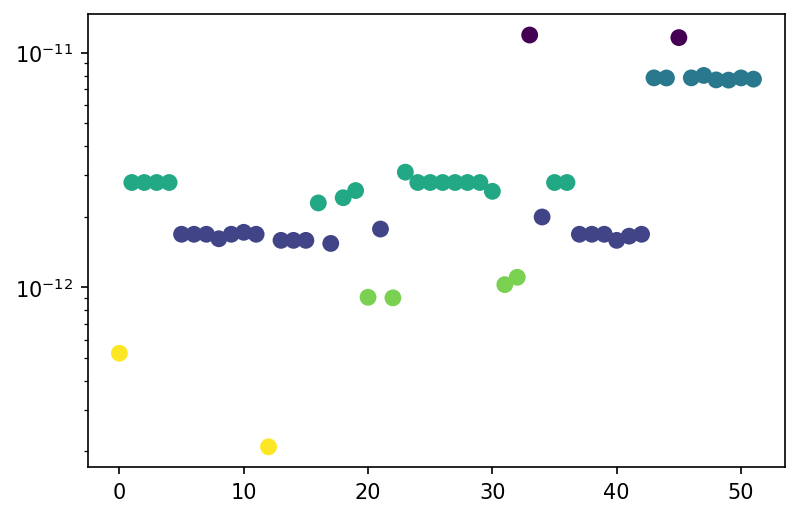

In [80]:
soil_clustering = {
    1:[75322, 75327, 75328, 75334, 75392, 75398, 75403, 75440, 75462,
            75482, 75485, 75506, 75508, 75511, 75514, 75661, 75670],
    2:[2756442, 2901079, 2901081, 2901082, 2901083, 2901084, 2901085,
            2901086],
    3:[ 75339,  75340,  75342,  75343,  75349,  75351,  75352,  75357,
             75359,  75361,  75394,  75413,  75654,  75691,  75693,  75694,
             75695,  75696, 679189],
    4:[75618, 2901080],
    5:[75404, 75414, 75572, 75586],
    6:[75318, 75356]
}

In [81]:
for i,v in soil_clustering.items():
    for j in v:
        if j in soil_prop_df.index:
            soil_prop_df.loc[j, 'cluster'] = i

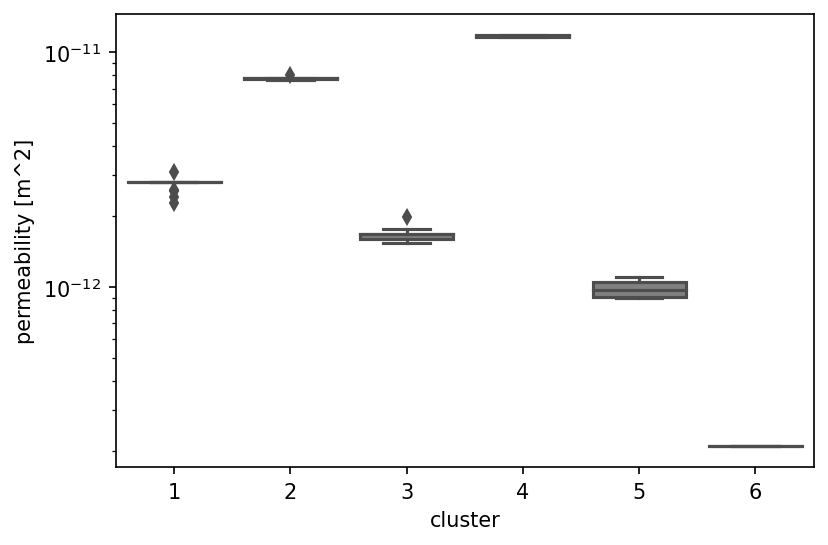

In [82]:
sns.boxplot(x = 'cluster', y = 'permeability [m^2]', data = soil_prop_df, color = 'gray')
plt.yscale('log')

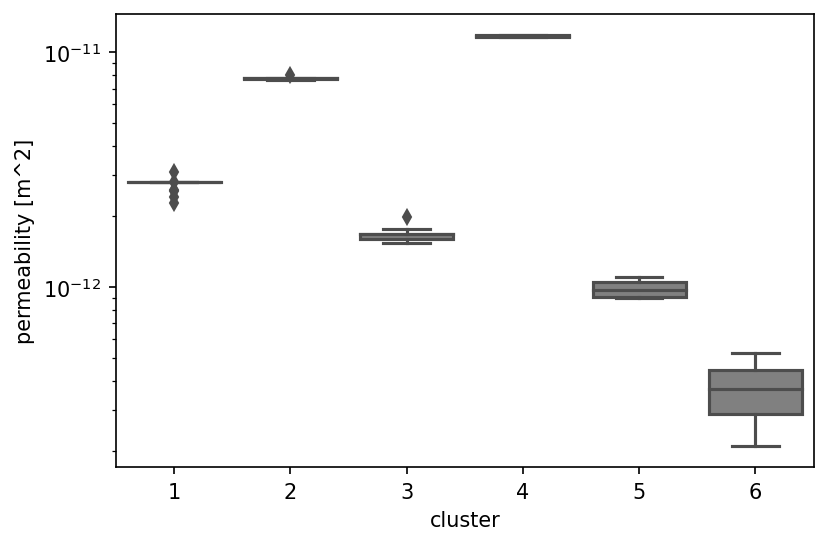

In [86]:
for i in np.arange(1,7):
    ids = soil_prop_df[soil_prop_df['cluster'] == i].index
    logging.info(f"cluster {i}: {ids}")

2022-03-23 22:42:27,531 - root - INFO: cluster 1: Int64Index([75322, 75327, 75328, 75334, 75392, 75398, 75403, 75440, 75462,
            75482, 75485, 75506, 75508, 75511, 75514, 75661, 75670],
           dtype='int64', name='mukey')
2022-03-23 22:42:27,532 - root - INFO: cluster 2: Int64Index([2756442, 2901079, 2901081, 2901082, 2901083, 2901084, 2901085,
            2901086],
           dtype='int64', name='mukey')
2022-03-23 22:42:27,533 - root - INFO: cluster 3: Int64Index([ 75339,  75340,  75342,  75343,  75349,  75351,  75352,  75357,
             75359,  75361,  75394,  75413,  75654,  75691,  75693,  75694,
             75695,  75696, 679189],
           dtype='int64', name='mukey')
2022-03-23 22:42:27,534 - root - INFO: cluster 4: Int64Index([75618, 2901080], dtype='int64', name='mukey')
2022-03-23 22:42:27,535 - root - INFO: cluster 5: Int64Index([75404, 75414, 75572, 75586], dtype='int64', name='mukey')
2022-03-23 22:42:27,536 - root - INFO: cluster 6: Int64Index([75356], dt

In [24]:
# original clustering for 250m-riverbed meshes

2021-09-07 13:35:29,655 - root - INFO: cluster 1: Int64Index([75322, 75327, 75328, 75334, 75392, 75398, 75403, 75440, 75462,
            75482, 75485, 75506, 75508, 75511, 75514, 75661, 75670],
           dtype='int64', name='mukey')
2021-09-07 13:35:29,657 - root - INFO: cluster 2: Int64Index([2756442, 2901079, 2901081, 2901082, 2901083, 2901084, 2901085,
            2901086],
           dtype='int64', name='mukey')
2021-09-07 13:35:29,658 - root - INFO: cluster 3: Int64Index([ 75339,  75340,  75342,  75343,  75349,  75351,  75352,  75357,
             75359,  75361,  75394,  75413,  75654,  75691,  75693,  75694,
             75695,  75696, 679189],
           dtype='int64', name='mukey')
2021-09-07 13:35:29,659 - root - INFO: cluster 4: Int64Index([75618, 2901080], dtype='int64', name='mukey')
2021-09-07 13:35:29,661 - root - INFO: cluster 5: Int64Index([75404, 75414, 75572, 75586], dtype='int64', name='mukey')
2021-09-07 13:35:29,662 - root - INFO: cluster 6: Int64Index([75318, 753

In [87]:
# soil_prop_df['cluster'] = cluster
soil_prop_df['logK'] = np.log10(soil_prop_df['permeability [m^2]'])
soil_prop_df['VGM_m'] = 1- 1/ (soil_prop_df['van Genuchten n [-]'])
soil_prop_df['logAlpha'] = np.log10(soil_prop_df['van Genuchten alpha [Pa^-1]'])

In [88]:
10**(soil_prop_df.groupby('cluster').mean()[['logAlpha']])

logAlpha
cluster          
1        0.000082
2        0.000092
3        0.000089
4        0.000189
5        0.000077
6        0.000062

In [89]:
soil_prop_df.groupby('cluster').mean()[[ 'VGM_m', 'residual saturation [-]', 'porosity [-]']]

VGM_m  residual saturation [-]  porosity [-]
cluster                                                 
1        0.333908                 0.148058      0.339403
2        0.351618                 0.136426      0.370137
3        0.330638                 0.151955      0.433716
4        0.469505                 0.137251      0.197469
5        0.303987                 0.189188      0.350712
6        0.274600                 0.237882      0.478026

In [90]:
soil_meanK = 10**(soil_prop_df.groupby('cluster').mean()[['logK']])

soil_meanK

logK
cluster              
1        2.732650e-12
2        7.785262e-12
3        1.671760e-12
4        1.175208e-11
5        9.824107e-13
6        2.093784e-13

In [91]:
new_soil_color = soil_color.copy()
for i in set(cluster):
    isoil = soil_prop_df[soil_prop_df['cluster'] == i].index
    idx = np.isin(new_soil_color, isoil)
    new_soil_color[idx] = int(i)  

np.unique(new_soil_color)

array([1, 2, 3, 4, 5, 6], dtype=int32)

/opt/anaconda3/envs/workflow-021121/lib/python3.9/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()


(420690.90789999993, 450480.0101, 163665.86095, 185768.07405000002)

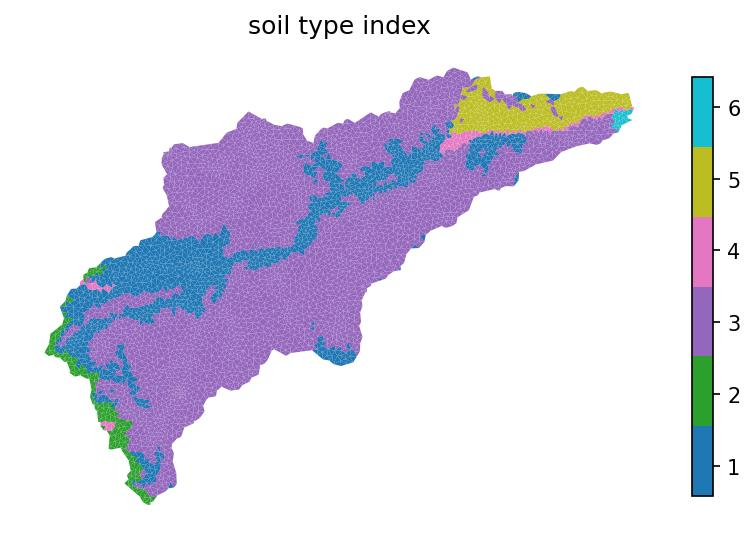

In [92]:
indices, cmap, norm, ticks, labels = workflow.colors.generate_indexed_colormap(new_soil_color, cmap = 'tab10')

# plot the soil mukey
fig = plt.figure(figsize=figsize)
ax = workflow.plot.get_ax(crs, fig)

polys = workflow.plot.mesh(m2, crs, ax=ax, facecolor='color',
                        linewidth=0, color=new_soil_color, 
                        cmap=cmap, norm = norm
                       )
workflow.colors.colorbar_index(ncolors=len(np.unique(new_soil_color)), cmap=cmap, labels = labels) 
 
ax.set_title('soil type index')
ax.axis("off")
# fig.savefig('watershed_soils')

/opt/anaconda3/envs/workflow-021121/lib/python3.9/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()


(420646.31965, 451406.66134999995, 163794.452, 185810.094)

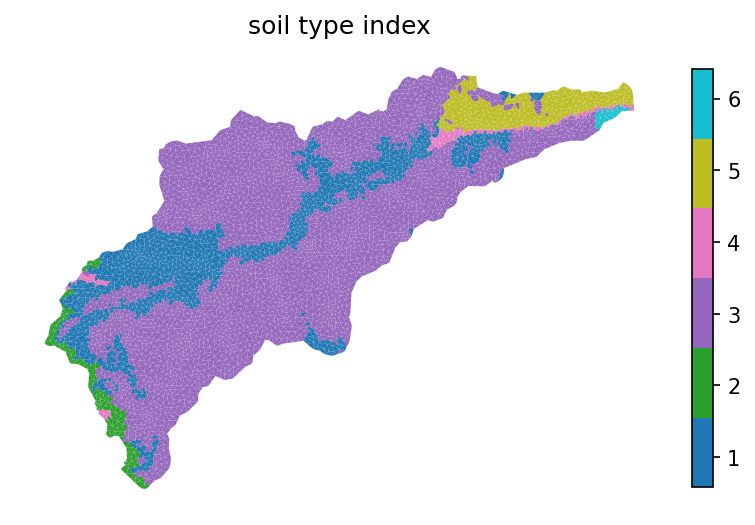

In [137]:
# soil_prop_df.to_csv("/Users/shua784/github/yakima/data/material/American_soil_prop-250m-riverbed-gapfill-clustered.csv")

## map geology

Manually download global geology map (GLHYMPS v2.0) from [here](https://dataverse.scholarsportal.info/dataset.xhtml?persistentId=doi:10.5683/SP2/TTJNIU), and put it under `./data/soil_structure/GLHYMPS`. The file size is about ~4 GB.

In [94]:
target_bounds = watershed.exterior().bounds

_, geo_survey, geo_survey_props = workflow.get_shapes(sources['geologic structure'],
                                                      target_bounds, crs,crs, properties=True)

# -- log the bounds targetted and found
logging.info('shape union bounds: {}'.format(
    shapely.ops.cascaded_union(geo_survey).bounds))

# -- determine the ID for each soil unit; this uniquely identifies formation
#    properties
geo_ids = np.array([shp.properties['id'] for shp in geo_survey], np.int32)

# -- color a raster by the polygons (this makes identifying a triangle's value much 
#    more efficient)
geo_color_raster, geo_color_profile, img_bounds = \
            workflow.color_raster_from_shapes(target_bounds, 10, geo_survey,
                                              geo_ids, crs)

# -- resample the raster to the triangles
geo_color = workflow.values_from_raster(m2.centroids(), crs, 
                                         geo_color_raster, geo_color_profile)

2022-03-23 22:51:53,871 - root - INFO: 
2022-03-23 22:51:53,872 - root - INFO: Loading shapes
2022-03-23 22:51:53,872 - root - INFO: ------------------------------
2022-03-23 22:51:53,873 - root - INFO: Getting shapes of GLHYMPS on bounds: (422044.9579910975, 164670.50734242608, 449125.96042868716, 184763.42768634777)
2022-03-23 22:51:53,873 - root - INFO:   from file: /Users/shua784/github/watershed-workflow/data_library/soil_structure/GLHYMPS/GLHYMPS.shp
2022-03-23 22:51:53,990 - fiona.ogrext - INFO: Failed to auto identify EPSG: 7
2022-03-23 22:52:00,343 - root - INFO: ... found 28 shapes
2022-03-23 22:52:00,343 - root - INFO: Converting to shapely
2022-03-23 22:52:00,365 - root - INFO: Converting to requested CRS
2022-03-23 22:52:00,565 - root - INFO: shape union bounds: (386911.3214970341, 112379.03856700905, 558658.3888897153, 233173.46442265552)
2022-03-23 22:52:00,566 - root - INFO: Coloring shapes onto raster:
2022-03-23 22:52:00,567 - root - INFO:   target_bounds = (422044.95

In [95]:
# select the properties that appear in the mesh
geo_survey_props.set_index('id', inplace=True, drop=False)
geo_survey_props = geo_survey_props.loc[np.unique(geo_color), :]

geo_survey_props

id   source  permeability [m^2]  logk_stdev [-]  porosity [-]  \
id                                                                          
736392  736392  GLHYMPS        3.162278e-13            1.80          0.09   
736625  736625  GLHYMPS        3.162278e-13            1.80          0.09   
736626  736626  GLHYMPS        3.162278e-13            1.80          0.09   
736686  736686  GLHYMPS        1.000000e-13            2.00          0.22   
736702  736702  GLHYMPS        7.943282e-15            1.50          0.01   
736710  736710  GLHYMPS        7.943282e-15            1.50          0.01   
736715  736715  GLHYMPS        3.162278e-13            1.80          0.09   
736747  736747  GLHYMPS        7.943282e-15            1.50          0.01   
736748  736748  GLHYMPS        7.943282e-15            1.50          0.01   
736799  736799  GLHYMPS        3.162278e-13            1.80          0.09   
754750  754750  GLHYMPS        3.019952e-11            1.61          0.01   

        van Genuchten alpha [Pa^-1]  van Genuchten n [-]  \
id                                                         
736392                     0.000817                  2.0   
736625                     0.000817                  2.0   
736626                     0.000817                  2.0   
736686                     0.000294                  2.0   
736702                     0.000388                  2.0   
736710                     0.000388                  2.0   
736715                     0.000817                  2.0   
736747                     0.000388                  2.0   
736748                     0.000388                  2.0   
736799                     0.000817                  2.0   
754750                     0.023953                  2.0   

        residual saturation [-]  
id                               
736392                     0.01  
736625                     0.01  
736626                     0.01  
736686                     0.01  
736702                     0.01  
736710                     0.01  
736715                     0.01  
736747                     0.01  
736748                     0.01  
736799                     0.01  
754750                     0.01

In [96]:
area_list = [areas[geo_color==i].sum() for i in np.unique(geo_color)]
assert(np.sum(area_list) == areas.sum())
area_coverage = np.array(area_list) / areas.sum() * 100

# geo_survey_props.set_index('id', inplace = True)
# sub_soil_props = soil_survey_props.loc[unique_soil_id,:]
geo_id_df = pd.DataFrame(np.array(np.unique(geo_color, return_counts=True)).T, columns = ['id', 'count'])
geo_id_df.set_index('id', inplace = True)
geo_id_df['area'] = area_list
geo_id_df['coverage [%]'] = area_coverage

geo_prop_df = geo_survey_props.merge(geo_id_df, how = 'inner', left_index = True, right_index = True, sort = True)
# geo_prop_df.to_csv(fname_geol_prop)

### plot geology map

/opt/anaconda3/envs/workflow-021121/lib/python3.9/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()


(420690.90789999993, 450480.0101, 163665.86095, 185768.07405000002)

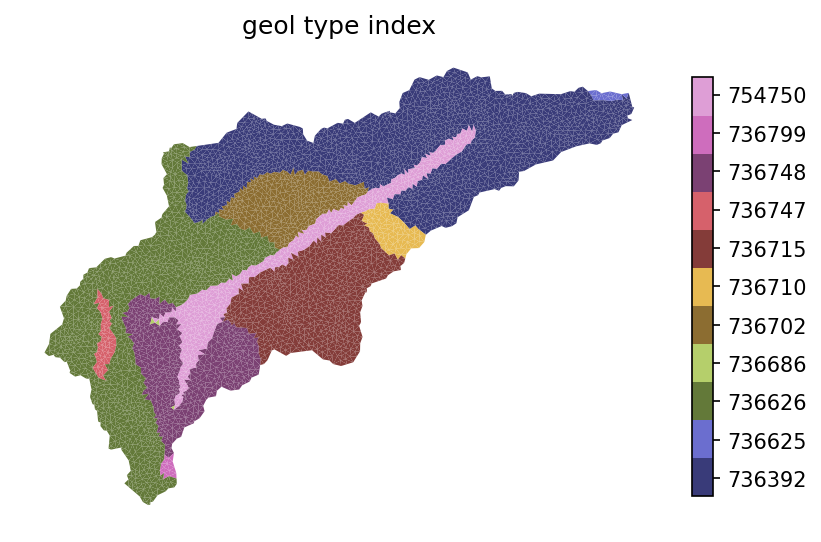

In [97]:
indices, cmap, norm, ticks, labels = workflow.colors.generate_indexed_colormap(geo_color, cmap = 'tab20b')

# plot the geologic formation id
fig = plt.figure(figsize=figsize)
ax = workflow.plot.get_ax(crs, fig)

mp = workflow.plot.mesh(m2, crs, ax=ax, facecolor='color',
                                 linewidth=0, color=geo_color, 
                        cmap=cmap, norm = norm
                        )

workflow.colors.colorbar_index(ncolors=len(np.unique(geo_color)), cmap=cmap, labels = labels) 

ax.set_title('geol type index')
ax.axis('off')
# ax.legend()

# fig.savefig(fig_geol_map, dpi = 300, transparent = True)

min, max =  0.01 0.22


Text(0.5, 1.0, 'porosity')

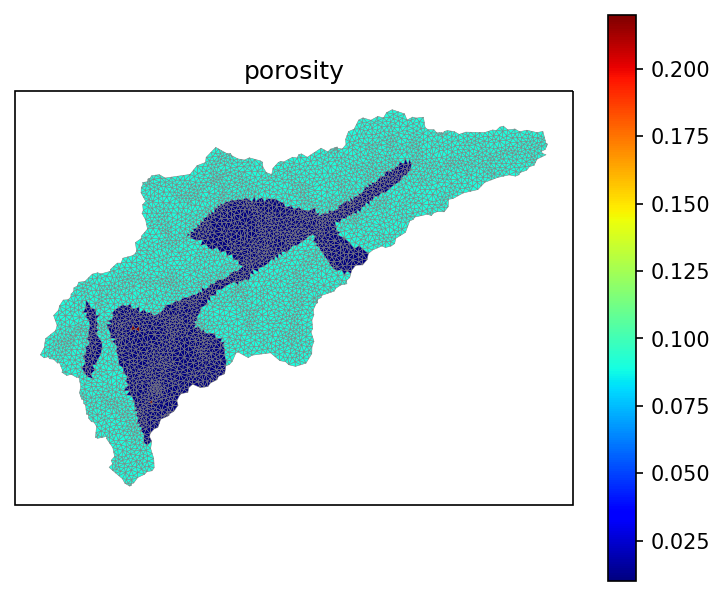

In [87]:
fig = plt.figure(figsize=(6,5))
porosity = np.empty(geo_color.shape, 'd')
# porosity_rosetta = np.empty(soil_color.shape, 'd')

for i in geo_prop_df.index:
    porosity[geo_color == i] = geo_prop_df.loc[i, 'porosity [-]']
#     porosity_rosetta[soil_color == mukey] = soil_survey_props.loc[soil_survey_props['mukey']==mukey,'Rosetta porosity [-]']

pmin = np.nanmin(porosity)
pmax = np.nanmax(porosity)
print('min, max = ', pmin, pmax)

ax1 = workflow.plot.get_ax(crs, fig, nrow=1, ncol=1, index=1)
mp = workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax1, 
                                 color=porosity, edgecolor='gray', cmap='jet', vmin=pmin, vmax=pmax)
cbar = fig.colorbar(mp)
ax1.set_title('porosity')

### k-means clustering

In [29]:
# geo_prop_df = pd.read_csv("/Users/shua784/github/yakima/data/material/American_geol_prop-250m-riverbed-gapfill.csv",
#                          index_col='id')

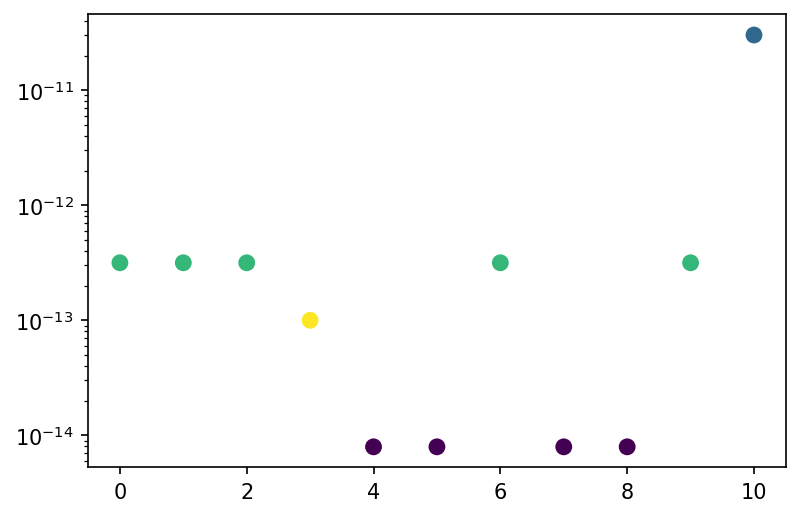

In [98]:
# kmeans = KMeans(n_clusters=4)
# X= geo_prop_df['permeability [m^2]'].values.reshape(-1, 1)
# kmeans.fit(X)
# y_kmeans = kmeans.predict(X)

# plt.scatter(np.arange(X.shape[0]), X[:, 0], c=y_kmeans, s=50, cmap='viridis')
# plt.yscale('log')

# cluster = y_kmeans + 1 # convert to 1-based index
# geo_prop_df['cluster'] = cluster

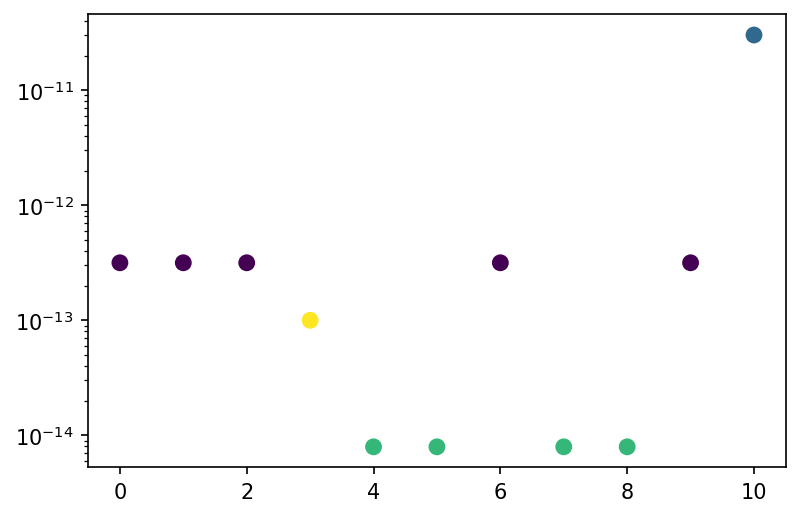

In [99]:
geo_clustering = {
    1:[736392, 736625, 736626, 736715, 736799],
    2:[754750],
    3:[736702, 736710, 736747, 736748],
    4:[736686]
}

In [104]:
for i,v in geo_clustering.items():
    for j in v:
        if j in geo_prop_df.index:
            geo_prop_df.loc[j, 'cluster'] = int(i)

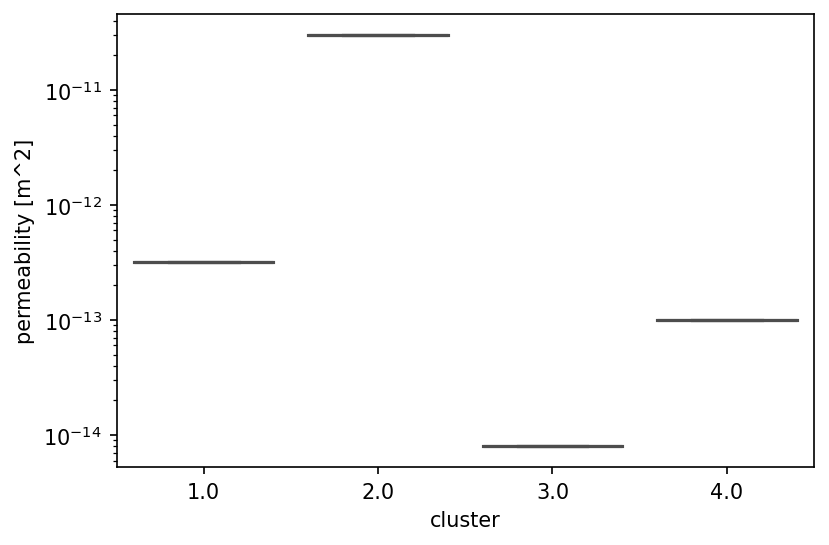

In [101]:
# import seaborn as sns
sns.boxplot(x = 'cluster', y = 'permeability [m^2]', data = geo_prop_df, color = 'gray')
plt.yscale('log')

In [107]:
geo_prop_df

id   source  permeability [m^2]  logk_stdev [-]  porosity [-]  \
id                                                                          
736392  736392  GLHYMPS        3.162278e-13            1.80          0.09   
736625  736625  GLHYMPS        3.162278e-13            1.80          0.09   
736626  736626  GLHYMPS        3.162278e-13            1.80          0.09   
736686  736686  GLHYMPS        1.000000e-13            2.00          0.22   
736702  736702  GLHYMPS        7.943282e-15            1.50          0.01   
736710  736710  GLHYMPS        7.943282e-15            1.50          0.01   
736715  736715  GLHYMPS        3.162278e-13            1.80          0.09   
736747  736747  GLHYMPS        7.943282e-15            1.50          0.01   
736748  736748  GLHYMPS        7.943282e-15            1.50          0.01   
736799  736799  GLHYMPS        3.162278e-13            1.80          0.09   
754750  754750  GLHYMPS        3.019952e-11            1.61          0.01   

        van Genuchten alpha [Pa^-1]  van Genuchten n [-]  \
id                                                         
736392                     0.000817                  2.0   
736625                     0.000817                  2.0   
736626                     0.000817                  2.0   
736686                     0.000294                  2.0   
736702                     0.000388                  2.0   
736710                     0.000388                  2.0   
736715                     0.000817                  2.0   
736747                     0.000388                  2.0   
736748                     0.000388                  2.0   
736799                     0.000817                  2.0   
754750                     0.023953                  2.0   

        residual saturation [-]  count          area  coverage [%]  cluster  
id                                                                           
736392                     0.01   2698  7.001049e+07     34.123740      1.0  
736625                     0.01     18  5.801351e+05      0.282763      1.0  
736626                     0.01   1770  4.759571e+07     23.198572      1.0  
736686                     0.01      3  8.020957e+04      0.039095      4.0  
736702                     0.01    538  1.354347e+07      6.601208      3.0  
736710                     0.01    134  3.972857e+06      1.936406      3.0  
736715                     0.01   1080  3.016356e+07     14.701990      1.0  
736747                     0.01     85  2.229563e+06      1.086709      3.0  
736748                     0.01    782  2.060897e+07     10.044994      3.0  
736799                     0.01     18  5.733806e+05      0.279471      1.0  
754750                     0.01    728  1.580819e+07      7.705052      2.0

source  permeability [m^2]  logk_stdev [-]  porosity [-]  \
id                                                                  
736392  GLHYMPS        3.162278e-13            1.80          0.09   
736625  GLHYMPS        3.162278e-13            1.80          0.09   
736626  GLHYMPS        3.162278e-13            1.80          0.09   
736686  GLHYMPS        1.000000e-13            2.00          0.22   
736702  GLHYMPS        7.943282e-15            1.50          0.01   
736710  GLHYMPS        7.943282e-15            1.50          0.01   
736715  GLHYMPS        3.162278e-13            1.80          0.09   
736747  GLHYMPS        7.943282e-15            1.50          0.01   
736748  GLHYMPS        7.943282e-15            1.50          0.01   
736799  GLHYMPS        3.162278e-13            1.80          0.09   
754750  GLHYMPS        3.019952e-11            1.61          0.01   

        depth to bedrock [m]  count          area  coverage [%]  cluster  
id                                                                        
736392                0.0000   2747  6.989187e+07     34.065652        1  
736625                0.0000     23  6.102377e+05      0.297433        1  
736626                0.0000   1770  4.759571e+07     23.198389        1  
736686                0.0000      3  8.020957e+04      0.039095        4  
736702                0.0000    538  1.354347e+07      6.601156        3  
736710                0.0000    139  3.991104e+06      1.945284        3  
736715                0.0000   1080  3.016356e+07     14.701874        1  
736747                0.0000     85  2.229563e+06      1.086700        3  
736748                0.0000    782  2.060897e+07     10.044915        3  
736799                0.0000     18  5.733806e+05      0.279469        1  
754750               19.2193    731  1.588008e+07      7.740033        2

In [45]:
# geo_prop_df.to_csv("/Users/shua784/github/yakima/data/material/American_geol_prop-250m-riverbed-gapfill-clustered.csv")

In [48]:
for i in np.unique(cluster):
    ids = geo_prop_df[geo_prop_df['cluster'] == i].index
    logging.info(f"cluster {i}: {ids}")   

2021-09-07 14:22:04,864 - root - INFO: cluster 1: Int64Index([736392, 736625, 736626, 736715, 736799], dtype='int64', name='id')
2021-09-07 14:22:04,865 - root - INFO: cluster 2: Int64Index([754750], dtype='int64', name='id')
2021-09-07 14:22:04,866 - root - INFO: cluster 3: Int64Index([736702, 736710, 736747, 736748], dtype='int64', name='id')
2021-09-07 14:22:04,868 - root - INFO: cluster 4: Int64Index([736686], dtype='int64', name='id')


In [49]:
geo_prop_df['logK'] = np.log10(geo_prop_df['permeability [m^2]'])
# geo_prop_df.groupby('cluster').mean()
geo_meanK = 10**(geo_prop_df.groupby('cluster').mean()[['logK']])

geo_meanK

logK
cluster              
1        3.162278e-13
2        3.019952e-11
3        7.943282e-15
4        1.000000e-13

In [47]:
geo_prop_df.groupby('cluster').mean()

permeability [m^2]  logk_stdev [-]  porosity [-]  \
cluster                                                     
1              3.162278e-13            1.80          0.09   
2              3.019952e-11            1.61          0.01   
3              7.943282e-15            1.50          0.01   
4              1.000000e-13            2.00          0.22   

         depth to bedrock [m]   count          area  coverage [%]   logK  
cluster                                                                   
1                      0.0000  1127.6  2.976695e+07     14.508563 -12.50  
2                     19.2193   731.0  1.588008e+07      7.740033 -10.52  
3                      0.0000   386.0  1.009328e+07      4.919514 -14.10  
4                      0.0000     3.0  8.020957e+04      0.039095 -13.00

In [108]:
new_geo_color = geo_color.copy()
for i in set(cluster):
    igeo = geo_prop_df[geo_prop_df['cluster'] == i].index
    idx = np.isin(new_geo_color, igeo)
    new_geo_color[idx] = int(i)  

np.unique(new_geo_color)

array([1, 2, 3, 4], dtype=int32)

/opt/anaconda3/envs/workflow-021121/lib/python3.9/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()


(420690.90789999993, 450480.0101, 163665.86095, 185768.07405000002)

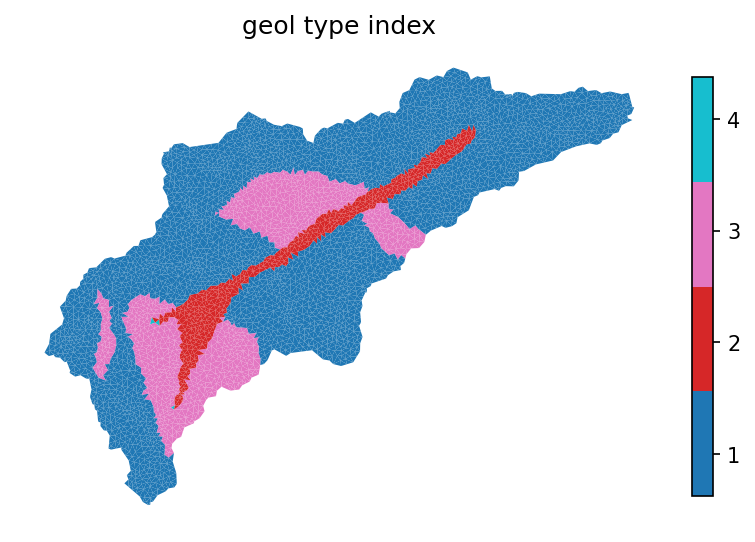

In [109]:
indices, cmap, norm, ticks, labels = workflow.colors.generate_indexed_colormap(new_geo_color, cmap = 'tab10')

# plot the geologic formation id
fig = plt.figure(figsize=figsize)
ax = workflow.plot.get_ax(crs, fig)

mp = workflow.plot.mesh(m2, crs, ax=ax, facecolor='color',
                                 linewidth=0, color=new_geo_color, 
                        cmap=cmap, norm = norm
                        )

gp.colorbar_index(ncolors=len(np.unique(new_geo_color)), cmap=cmap, labels = np.unique(new_geo_color)) 

ax.set_title('geol type index')
ax.axis('off')
# print(geo_survey_props)

# fig.savefig('watershed_geology')

(420646.31965, 451406.66134999995, 163794.452, 185810.094)

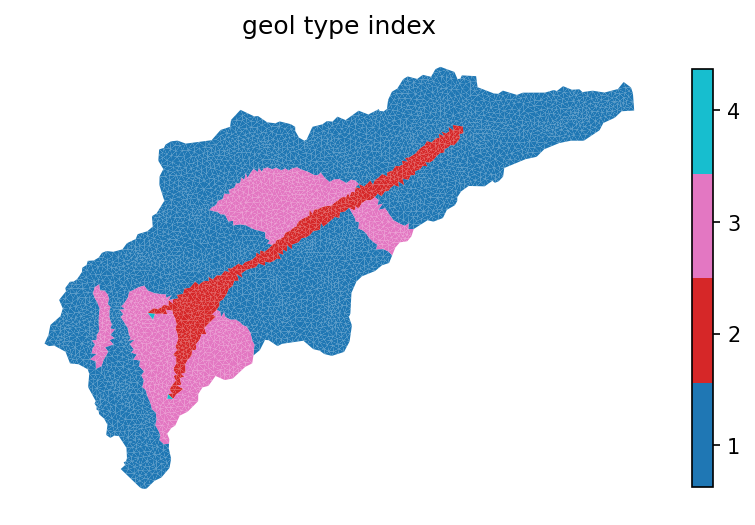

## get bedrock depth

Mannually download global depth to bedrock at 250 m resolution from [soilgrids](http://globalchange.bnu.edu.cn/research/dtb.jsp).

In [110]:
DTB_profile, DTB_raster = workflow.get_raster_on_shape(fname_DTB, watershed.exterior(), crs, nodata=-99999)

2022-03-23 23:14:37,619 - root - INFO: 
2022-03-23 23:14:37,619 - root - INFO: Loading Raster
2022-03-23 23:14:37,620 - root - INFO: ------------------------------
2022-03-23 23:14:37,620 - root - INFO: Loading file: '/Users/shua784/Dropbox/PNNL/Projects/Columbia_Basin/Reach_domain_QGIS/global/depth-to-bedrock/Global_absoluteDTB_M_250m_ll.tif'
2022-03-23 23:14:37,621 - root - INFO: Collecting raster
2022-03-23 23:14:37,740 - root - INFO: bounds in my_crs: (-121.52267188195283, 46.81084247536741, -121.16868167776585, 46.992974901986386)
2022-03-23 23:14:37,762 - root - INFO: ... got raster of shape: (89, 171)
2022-03-23 23:14:37,781 - root - INFO: ... got raster bounds: (-121.522926023, 46.99500646, -121.16667608, 46.809589822999996)


In [ ]:
# resample the raster to the triangles
DTB_raster = DTB_raster/100 #convert from cm to m
DTB = workflow.values_from_raster(m2.centroids(), crs, DTB_raster, DTB_profile)
DTB = np.where(DTB >= 0, DTB, np.nan)

In [112]:
logging.info(f'minimum depth-to-bedrock: {np.nanmin(DTB)} m')
logging.info(f'maximum depth-to-bedrock: {np.nanmax(DTB)} m')

2022-03-23 23:14:54,731 - root - INFO: minimum depth-to-bedrock: 6.56 m
2022-03-23 23:14:54,732 - root - INFO: maximum depth-to-bedrock: 24.14 m


Text(0.5, 1.0, 'DTB [m]')

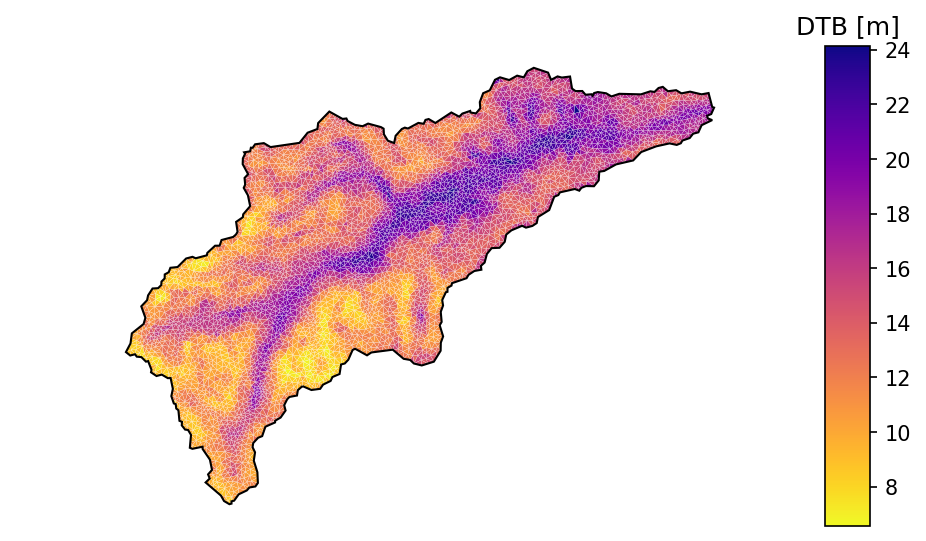

In [113]:
# plot the resulting surface mesh
fig, ax = workflow.plot.get_ax(crs, window=[0.05,0.1,0.9,0.8])
cbax = fig.add_axes([.95,0.1,0.05,0.8])

mp = workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax, 
                                 color=DTB, cmap='plasma_r', edgecolor='white', linewidth=0.1)
cbar = fig.colorbar(mp, orientation="vertical", cax=cbax)
workflow.plot.hucs(watershed, crs, ax=ax, color='k', linewidth=1)

ax.set_aspect('equal', 'datalim')
ax.axis('off')

cbar.ax.set_title('DTB [m]')

## Mesh extrusion

Given the surface mesh and material IDs on both the surface and subsurface, we can extrude the surface mesh in the vertical to make a 3D mesh.

In [114]:
total_tckness = np.ceil(DTB.max())
logging.info(f'total thickness: {total_tckness} m')

2022-03-23 23:15:03,893 - root - INFO: total thickness: 25.0 m


In [115]:
ele_per_layer = mesh_tris.shape[0]

In [116]:
dzs = [0.25, 0.25, 0.5, 1.0]

In [151]:
# layer extrusion
# -- data structures needed for extrusion
layer_types = []
layer_data = []
layer_ncells = []
layer_mat_ids = []

# -- soil layer --
for dz in dzs:
    layer_types.append('constant')
    layer_data.append(dz)
    layer_ncells.append(1)
    layer_mat_ids.append(soil_color)
    
# -- geologic layer --
# keep going for 2m cells until we hit the bottom of
# the domain
dz = 2.0
geo_ncells = int(np.ceil((total_tckness- sum(dzs))/dz))
for i in range(geo_ncells):
    layer_types.append('constant')
    layer_data.append(dz)
    layer_ncells.append(1)
    layer_mat_ids.append(geo_color)

# print the summary
workflow.mesh.Mesh3D.summarize_extrusion(layer_types, layer_data, 
                                            layer_ncells, layer_mat_ids)

2022-03-24 10:41:09,882 - root - INFO: Cell summary:
2022-03-24 10:41:09,883 - root - INFO: ------------------------------------------------------------
2022-03-24 10:41:09,884 - root - INFO: l_id	| c_id	|mat_id	| dz		| z_top
2022-03-24 10:41:09,884 - root - INFO: ------------------------------------------------------------
2022-03-24 10:41:09,885 - root - INFO:  00 	| 00 	| 75351 	|   0.250000 	|   0.000000
2022-03-24 10:41:09,885 - root - INFO:  01 	| 01 	| 75351 	|   0.250000 	|   0.250000
2022-03-24 10:41:09,885 - root - INFO:  02 	| 02 	| 75351 	|   0.500000 	|   0.500000
2022-03-24 10:41:09,886 - root - INFO:  03 	| 03 	| 75351 	|   1.000000 	|   1.000000
2022-03-24 10:41:09,886 - root - INFO:  04 	| 04 	| 736626 	|   2.000000 	|   2.000000
2022-03-24 10:41:09,887 - root - INFO:  05 	| 05 	| 736626 	|   2.000000 	|   4.000000
2022-03-24 10:41:09,887 - root - INFO:  06 	| 06 	| 736626 	|   2.000000 	|   6.000000
2022-03-24 10:41:09,888 - root - INFO:  07 	| 07 	| 736626 	|   2.000

In [152]:
logging.info(f"No of cells: {len(layer_data)*ele_per_layer}")

2022-03-24 10:41:24,899 - root - INFO: No of cells: 125664


**add layer ids**

In [121]:
# mat_ids = np.arange(1, len(layer_data)+1) # layer ids
# new_layer_mat_ids = [np.array([i]*ele_per_layer, dtype=int) for i in mat_ids]
# layer_mat_ids, len(layer_mat_ids), layer_mat_ids[0].shape
# new_layer_mat_ids, len(new_layer_mat_ids), new_layer_mat_ids[0].shape
# layer_mat_ids = new_layer_mat_ids

### add bedrock material

In [153]:
bedrock_id = 999
riverbed_id = 100
unique_mat_ids = geo_prop_df.index.tolist() + soil_prop_df.index.tolist() + [bedrock_id] + [riverbed_id]

if len(unique_mat_ids) != len(set(unique_mat_ids)): 
    raise RuntimeWarning('Common id is found in either soil/geol/bedrock/riverbed ids!')

In [154]:
# get depth of each layer
z_elev = np.cumsum(np.array([0] + dzs + [dz]*geo_ncells))
z_center = z_elev[:-1] + (z_elev[1:] - z_elev[:-1])/2

mat_ids = np.stack(layer_mat_ids)

for icol in np.arange(mat_ids.shape[1])[:]:
    idtb = DTB[icol]
    idx = z_center > idtb
    
    # assign 999 to bedrock
    mat_ids[idx, icol] = bedrock_id

layer_mat_ids = [mat_ids[row, :] for row in np.arange(mat_ids.shape[0])]

### add riverbed material

In [155]:
if riverbed_tckness > 0:
    alluvium_tck = riverbed_tckness # m
    layer_idx = sum(z_center < alluvium_tck) # find the top layers with a total thickness < riverbed thickness
    for ilayer in range(layer_idx):
        mat_ids[ilayer, river_idx] = riverbed_id

### extrusion

Extruded 3-D mesh has layer ordered bottom up?

In [156]:
layer_mat_ids = [mat_ids[row, :] for row in np.arange(mat_ids.shape[0])]

# extrude
m3 = workflow.mesh.Mesh3D.extruded_Mesh2D(m2, layer_types, layer_data, 
                                             layer_ncells, layer_mat_ids)

### add sidesets from land cover type

In [157]:
ss_names = [m3.side_sets[i].name for i in range(len(m3.side_sets))]
ss_ids = [m3.side_sets[i].setid for i in range(len(m3.side_sets))]

In [158]:
assert(ss_names.index('surface')==1)# surface sideset has id=1
# add back on land cover side sets
surf_ss = m3.side_sets[1] 

for index, name in zip(nlcd_indices, nlcd_labels):
    where = np.where(lc == index)[0]
    ss = workflow.mesh.SideSet(name, int(index), 
                            [surf_ss.elem_list[w] for w in where],
                            [surf_ss.side_list[w] for w in where])        
    m3.side_sets.append(ss)

In [172]:
print('Extruded 3D side sets')
print('---------------------')
ss = m3.side_sets
for i in ss:
    print(f'{i.setid} : FACE : {len(i.elem_list)} : "{i.name}"')

Extruded 3D side sets
---------------------
1 : FACE : 7854 : "bottom"
2 : FACE : 7854 : "surface"
3 : FACE : 5536 : "external_sides"
11 : FACE : 11 : "Open Water"
21 : FACE : 43 : "Developed, Open Space"
22 : FACE : 31 : "Developed, Low Intensity"
23 : FACE : 2 : "Developed, Medium Intensity"
24 : FACE : 1 : "Developed, High Intensity"
31 : FACE : 70 : "Barren Land"
41 : FACE : 6 : "Deciduous Forest"
42 : FACE : 6563 : "Evergreen Forest"
43 : FACE : 3 : "Mixed Forest"
52 : FACE : 757 : "Shrub/Scrub"
71 : FACE : 219 : "Grassland/Herbaceous"
81 : FACE : 16 : "Pasture/Hay"
90 : FACE : 125 : "Woody Wetlands"
95 : FACE : 7 : "Emergent Herbaceous Wetlands"


**group landcover types**

In [106]:
# lc_dict = {j:i for i,j in zip(nlcd_indices, nlcd_labels)}

# groups = {
#     'evergreen forest' : [lc_dict['Evergreen Forest'], lc_dict['Mixed Forest'], lc_dict['Deciduous Forest']],
#     'shrub': [lc_dict[i] for i in ['Shrub/Scrub', 'Grassland/Herbaceous', 'Woody Wetlands', 'Pasture/Hay',
#                                   'Emergent Herbaceous Wetlands']],
#     'other': [lc_dict[i] for i in ['Barren Land', 'Developed, Open Space', 'Developed, Low Intensity', 
#                                   'Developed, Medium Intensity', 'Developed, High Intensity', 'Open Water']]
# }

# group_ids = {
#     'evergreen forest' : 97,
#     'shrub': 98,
#     'other': 99
# }

# for iname,iid in group_ids.items():
#     idx = np.concatenate([np.where(lc == i)[0] for i in groups[iname]])

#     ss = workflow.mesh.SideSet(iname, iid, 
#                             [surf_ss.elem_list[w] for w in idx],
#                             [surf_ss.side_list[w] for w in idx])        
#     m3.side_sets.append(ss)    

In [173]:
with open(f"../data/WW_outputs/{watershed_name}_m3_{meshRes}.p", "wb") as f:
    pickle.dump(m3, f, protocol=-1)

## save to exodus file

In [160]:
# save to disk
try:
    os.remove(fname_final_mesh)
except FileNotFoundError:
    pass
m3.write_exodus(fname_final_mesh)

Opening exodus file: ../data/meshes/American_riverbed_res250m_tck0.0m.exo
Closing exodus file: ../data/meshes/American_riverbed_res250m_tck0.0m.exo
